# Co-binding Motif Analysis

In [1]:
### header ###
__author__ = "Jenhan Tao"
__license__ = "BSD"
__email__ = "jenhantao@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
sys.path.append("/home/jenhan/code/seq_merge_pipe/")
import os
import pandas as pd
import numpy as np
import argparse
import matplotlib
import itertools
import scipy
import matplotlib.pyplot as plt 
import seaborn as sns
from IPython.display import Image, display
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
import scipy
matplotlib.pylab.rcParams['savefig.dpi'] = 200
sys.setrecursionlimit(3000)
os.chdir('/home/jenhan/analysis/ncor_analysis/')
import pickle
sns.set_context('talk')

/bioinformatics/software/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Generate Score Files

### Convert motif files

### Create group summary file

In [99]:
# create group summary file
!bash /home/jenhan/code/seq_merge_pipe/makeSummaryFile.sh /home/jenhan/analysis/ncor_analysis/peak_files/* > /home/jenhan/analysis/ncor_analysis/output/group_summary.tsv
! cp merged.tsv /home/jenhan/analysis/ncor_analysis/group/merged_peaks.tsv

	Max distance to merge: direct overlap required (-d given)
	Merging peaks... 
	Comparing /home/jenhan/analysis/ncor_analysis/peak_files/ncor_kla_peaks.tsv (9466 total) and /home/jenhan/analysis/ncor_analysis/peak_files/ncor_kla_peaks.tsv (9466 total)
	Comparing /home/jenhan/analysis/ncor_analysis/peak_files/ncor_kla_peaks.tsv (9466 total) and /home/jenhan/analysis/ncor_analysis/peak_files/ncor_notx_peaks.tsv (5779 total)
	Comparing /home/jenhan/analysis/ncor_analysis/peak_files/ncor_notx_peaks.tsv (5779 total) and /home/jenhan/analysis/ncor_analysis/peak_files/ncor_kla_peaks.tsv (9466 total)
	Comparing /home/jenhan/analysis/ncor_analysis/peak_files/ncor_notx_peaks.tsv (5779 total) and /home/jenhan/analysis/ncor_analysis/peak_files/ncor_notx_peaks.tsv (5779 total)



### Retrieve sequences under peaks for finding motifs

In [100]:
%%capture
# get sequences to scan for motifsx`
!/home/jenhan/code/motif_tools/getTargetSequencesWrapper.sh /home/jenhan/analysis/ncor_analysis/group/ /home/jenhan/analysis/ncor_analysis/group 100


## Annotate with GRO-seq, H3K27Ac, and PolII

In [ ]:
%%capture
!annotatePeaks.pl /home/jenhan/analysis/ncor_analysis/group/merged_peaks.tsv mm10 -size 1000 -d /data/mm10/ThioMac/ChIP/PolII/Thio-C57BL6-siCtl-PolII-KLA-Josh /data/mm10/ThioMac/ChIP/PolII/Thio-C57BL6-siCtl-PolII-Veh-Josh /data/mm10/ThioMac/ChIP/PolII/WT-ThioMac-PolII-KLA-Josh /data/mm10/ThioMac/ChIP/PolII/WT-ThioMac-PolII-Veh-Josh /data/mm10/ThioMac/ChIP/H3K27Ac/C57BL6-Thio-H3K27Ac-KLA-1h-CR-12-07-06 /data/mm10/ThioMac/ChIP/H3K27Ac/C57BL6-Thio-H3K27Ac-notx-CR-12-07-06 /data/mm10/ThioMac/GRO/ThioMac-GroSeq-notx-1h_NJS_10-08-13 /data/mm10/ThioMac/GRO/ThioMac-GroSeq-notx-1h_NJS_10-09-01 /data/mm10/ThioMac/GRO/ThioMac-GroSeq-KLA-1h_NJS_10-08-13 /data/mm10/ThioMac/GRO/ThioMac-GroSeq-KLA-1h_NJS_10-09-01 > merged_annotated_peaks.tsv

### Scan for motifs using FIMO

In [103]:
# create a script to scan for motifs using FIMO
! if [ ! -d /home/jenhan/analysis/cobinding_motif_analysis/fimo_out/ ]; then mkdir /home/jenhan/analysis/cobinding_motif_analysis/fimo_out/; fi
pthresh = 0.01
motif_dir = '/home/jenhan/analysis/ncor_analysis/fimo_motifs/'

fimo_results_dir = '/home/jenhan/analysis/ncor_analysis/fimo_results'
p='/home/jenhan/analysis/ncor_analysis/group/merged.fa'
count = 0
scriptFile = open('scanMotifs.sh','w')
for m in os.listdir(motif_dir):
    if 'fimo' in m:
        fimo_out_dir = '/home/jenhan/analysis/ncor_analysis/fimo_out/' + m.replace('.fimo','')
        outPath = fimo_results_dir + '/merged_'+ m.replace('.fimo','') +'.txt'
        scriptFile.write(
            '(sleep ' + str(30 * 0) + 
            's; fimo --max-stored-scores 2000000 --output-pthresh ' + 
            str(pthresh) +' --oc ' + fimo_out_dir + ' ' +
            motif_dir + '/' + m + ' /home/jenhan/analysis/ncor_analysis/group/merged.fa; '+
            'mv ' + fimo_out_dir + '/fimo.txt ' + 
            outPath + ' ) & \n')
        count+=1
scriptFile.close()

!bash scanMotifs.sh

## Read in Score Files

### Read in Peak scores as floating point and boolean values

In [27]:
# read in peak data data
summary_frame = pd.read_csv('/home/jenhan/analysis/ncor_analysis/output/group_summary.tsv' , sep='\t')
summary_frame = summary_frame.fillna('0')
for col in summary_frame.columns[4:]:
    floatValues = []
    for val in summary_frame[col].values.astype(str):
        if ',' in val:
            maxVal = np.max([float(x) for x in val.split(',')])
            floatValues.append(maxVal)
        else:
            floatValues.append(float(val))
    summary_frame[col] = floatValues
    
summary_frame['chr'] = [x.split(':')[0] for x in summary_frame['Position'].values]
summary_frame['numFactors'] = [len(x.split(',')) for x in summary_frame['Factors'].values]
summary_frame.index = summary_frame['ID'].values
newCols = list(summary_frame.columns.values)[:4] + ['chr', 'numFactors'] + list(summary_frame.columns.values)[4:-2]
summary_frame = summary_frame[newCols]

del summary_frame['Group Number']
del summary_frame['numFactors']

bool_frame = summary_frame.copy()
bool_frame.index = summary_frame.index
del bool_frame['Position']
del bool_frame['chr']
del bool_frame['Factors']
del bool_frame['ID']


bool_frame['chr'] =summary_frame['chr']
bool_frame = bool_frame[['chr'] + list(bool_frame.columns.values[:-1])]


kla_cols= ['chr']
notx_cols = ['chr']
for col in bool_frame.columns:
    if 'kla' in col:
        kla_cols.append(col)
    elif 'notx' in col:
        notx_cols.append(col)
        
bool_frame_kla = bool_frame[kla_cols]
bool_frame_kla = bool_frame_kla[bool_frame_kla.sum(axis=1)>0]

bool_frame_notx = bool_frame[notx_cols]
bool_frame_notx = bool_frame_notx[bool_frame_notx.sum(axis=1)>0]

bool_frame.to_pickle('bool_frame.pickle')


factors = sorted(list(set([x.split('_')[0] for x in bool_frame.columns if '_' in x])))

## Read in GRO, PolII, and H3K27Ac scores

In [28]:
# read in GRO, PolII, and H3K27Ac scores
data_frame = pd.read_csv('merged_annotated_peaks.tsv', sep='\t')
data_frame.index=data_frame.ix[:,0].values
columns = data_frame.columns.values
columns[0] = 'ID'
columns = [x.split('/')[-1].split()[0] if '/' in x else x for x in columns]
data_frame.columns = columns
data_frame['PolII-KLA'] = np.mean(data_frame[['Thio-C57BL6-siCtl-PolII-KLA-Josh', 
                                               'WT-ThioMac-PolII-KLA-Josh']], axis=1)
data_frame['PolII-notx'] = np.mean(data_frame[['Thio-C57BL6-siCtl-PolII-Veh-Josh', 
                                               'WT-ThioMac-PolII-Veh-Josh']], axis=1)
data_frame['H3K27Ac-KLA'] = np.mean(data_frame[['C57BL6-Thio-H3K27Ac-KLA-1h-CR-12-07-06', 
                                               'C57BL6-Thio-H3K27Ac-KLA-1h-CR-12-07-06']], axis=1)
data_frame['H3K27Ac-notx'] = np.mean(data_frame[['C57BL6-Thio-H3K27Ac-notx-CR-12-07-06', 
                                               'C57BL6-Thio-H3K27Ac-notx-CR-12-07-06']], axis=1)
data_frame['Gro-KLA'] = np.mean(data_frame[['ThioMac-GroSeq-KLA-1h_NJS_10-08-13', 
                                               'ThioMac-GroSeq-KLA-1h_NJS_10-09-01']], axis=1)
data_frame['Gro-notx'] = np.mean(data_frame[['ThioMac-GroSeq-notx-1h_NJS_10-08-13', 
                                               'ThioMac-GroSeq-notx-1h_NJS_10-09-01']], axis=1)
data_frame = data_frame[['ID'] + list(data_frame.columns.values[-6:])]
summary_frame = summary_frame.merge(data_frame, on='ID')
summary_frame.index = summary_frame['ID'].values


# remove outlier GRO-seq values
summary_frame.loc[summary_frame['Gro-notx'] > 10000, 'Gro-notx' ] = 0
summary_frame.loc[summary_frame['Gro-KLA'] > 10000, 'Gro-kla' ] = 0
summary_frame.to_pickle('summary_frame.pickle')

### Read in motif scores

In [12]:
motif_dir = '/home/jenhan/analysis/ncor_analysis/fimo_motifs/'
merged_motif_frame = summary_frame[['ID', 'Factors', 'chr']]
merged_motif_frame.index=merged_motif_frame['ID'].values
for m in os.listdir(motif_dir):
    if '.fimo' in m:
        motif_results = './fimo_results/merged_' + m.replace('.fimo','') +'.txt'
        fimo_result_frame=pd.read_csv(motif_results, sep='\t')
        motif_name = m.replace('.fimo','')
        id_score_dict = {}
        ids = fimo_result_frame['sequence name'].values
        scores = fimo_result_frame['score'].values
        for i in range(len(ids)):
            if ids[i] in id_score_dict:
                if scores[i] > id_score_dict[ids[i]]:
                    id_score_dict[ids[i]] = scores[i]
            else:
                id_score_dict[ids[i]] = scores[i]
        merged_motif_frame[motif_name] = [id_score_dict[x] if x in id_score_dict else 0 for x in merged_motif_frame['ID'].values]
merged_motif_frame.to_pickle('motif_frame.pickle')



## Analysis of motif scores peak scores

### Plot Distributions of peak and motif scores

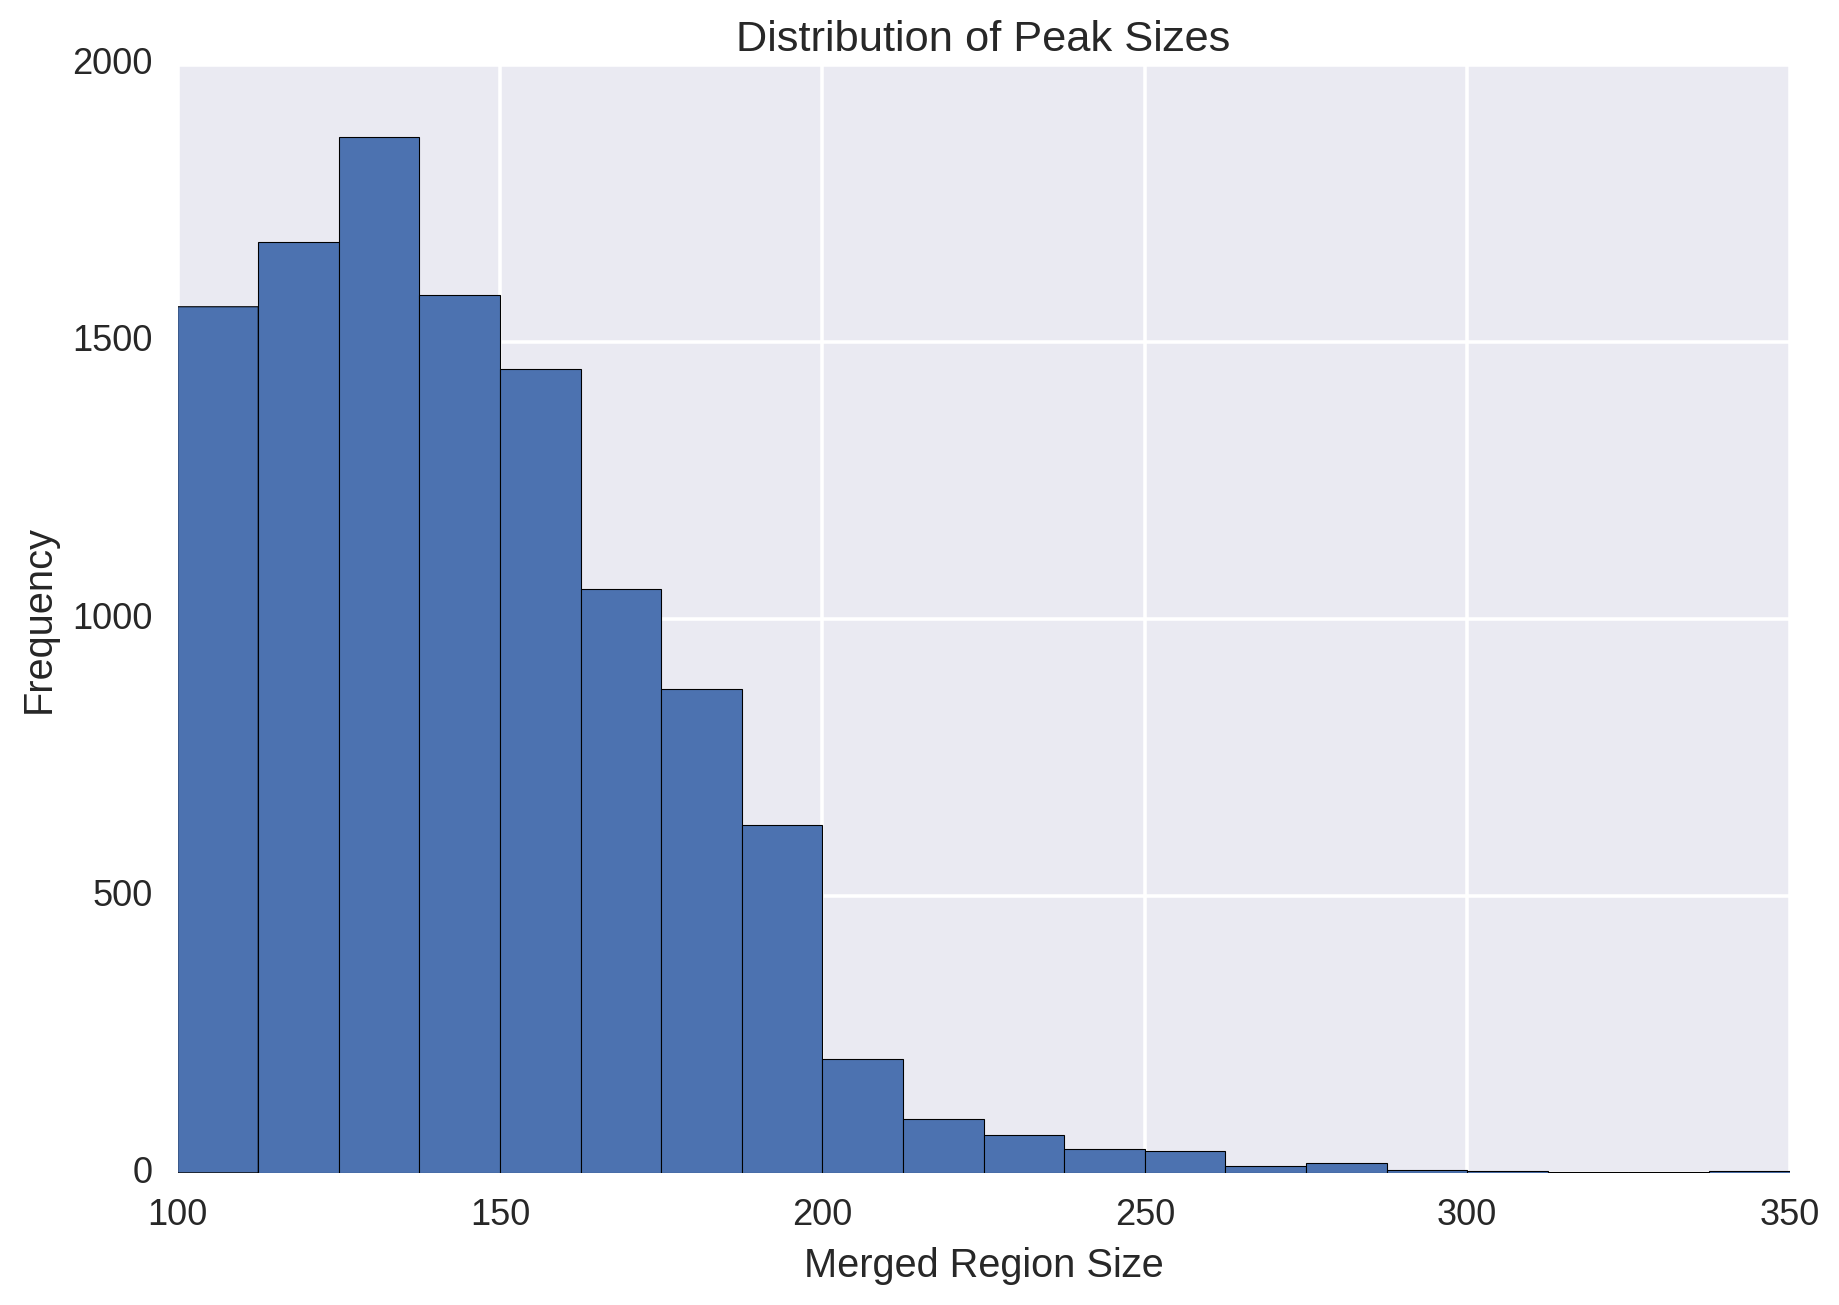

In [29]:
merged_motif_frame=pd.read_pickle('motif_frame.pickle')
summary_frame = pd.read_pickle('summary_frame.pickle')

# plot motif positions to make sure that nothing went wrong with the merging
positions = [x.split(':')[1] for x in summary_frame['Position'].values]
sizes = [int(x.split('-')[1]) - int(x.split('-')[0]) for x in positions]
plt.hist(sizes, bins = 20);
plt.xlabel('Merged Region Size')
plt.ylabel('Frequency')
plt.title('Distribution of Peak Sizes')

/bioinformatics/software/anaconda3/lib/python3.4/site-packages/seaborn/categorical.py:1613: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)
/bioinformatics/software/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


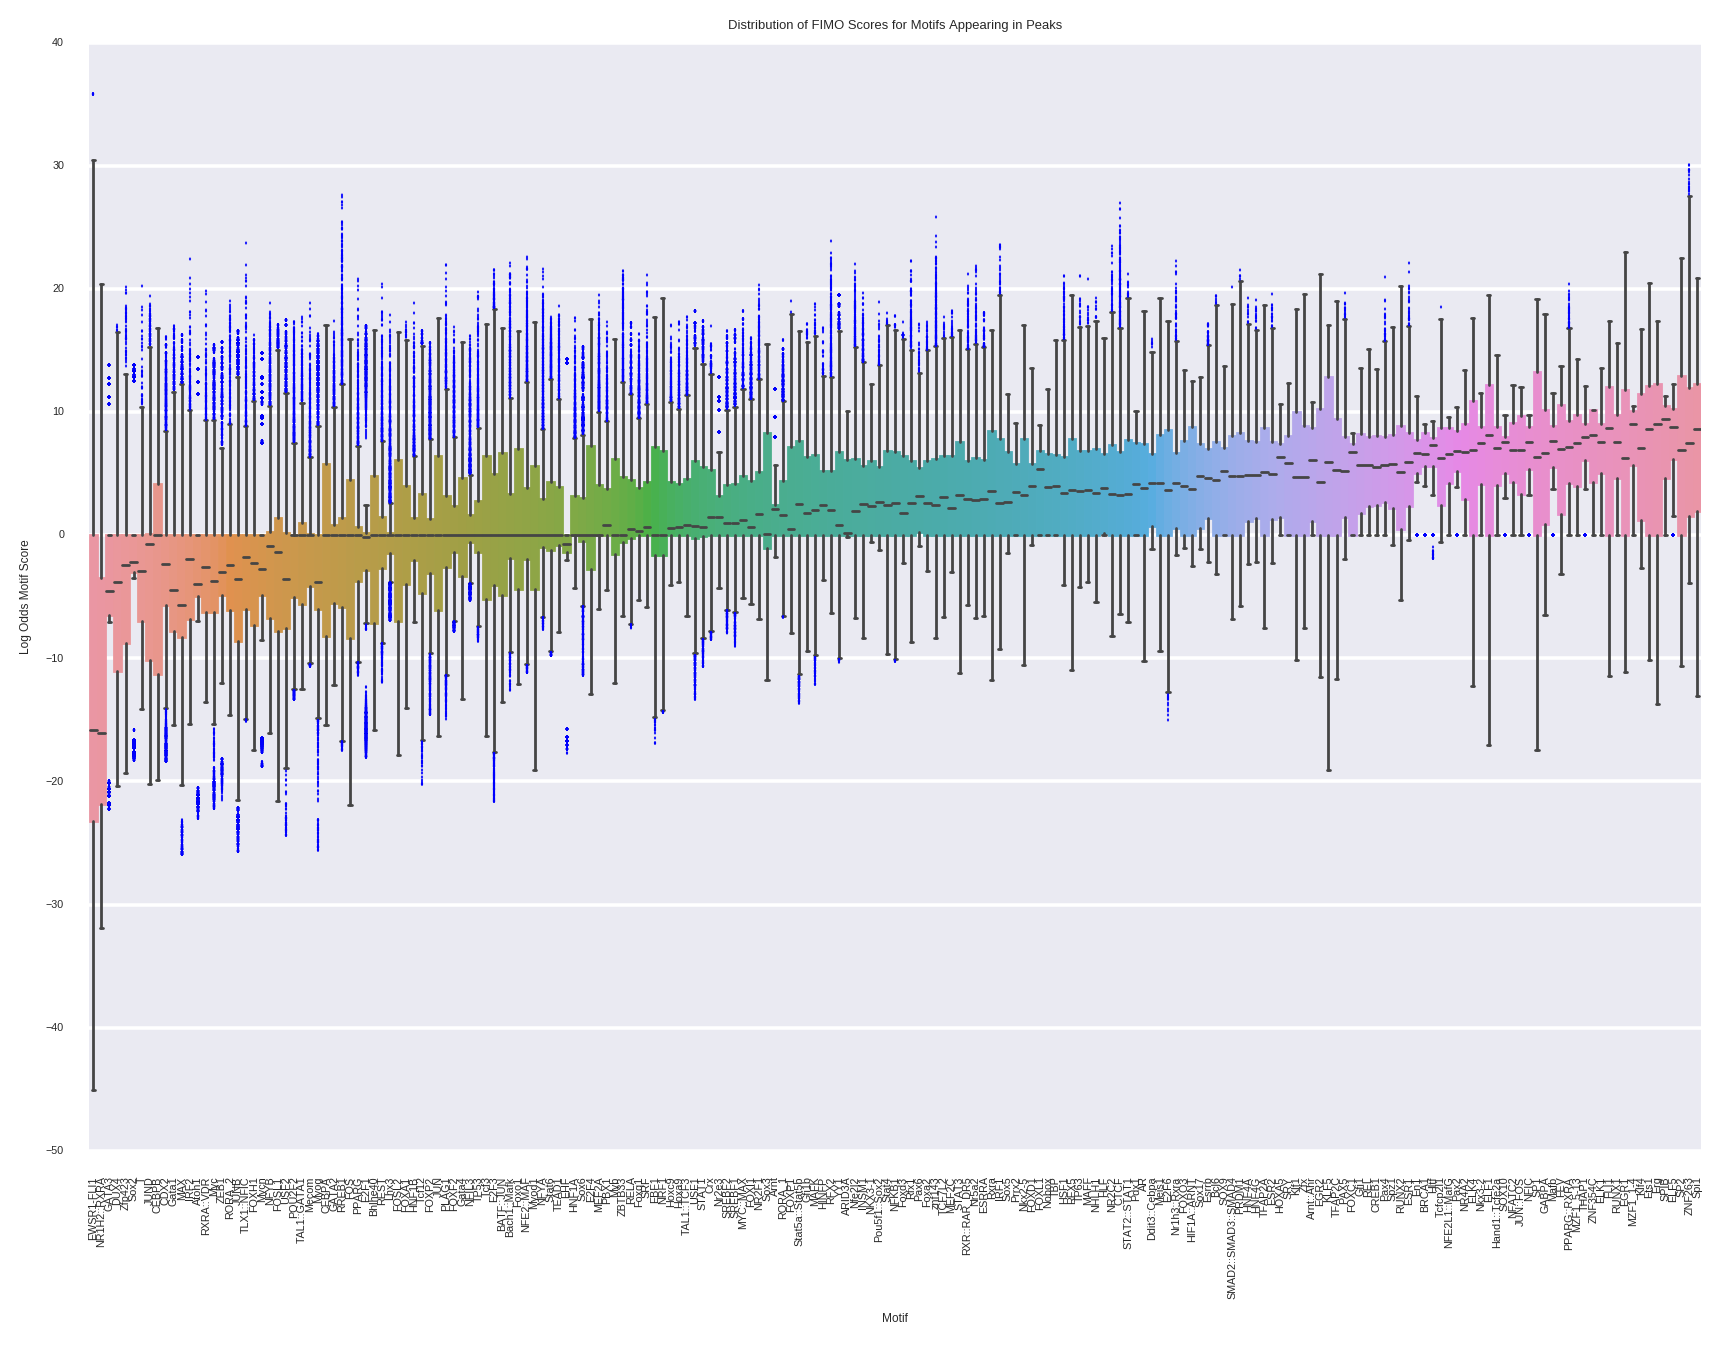

In [14]:
# plot distribution of motif scores
sns.set_context('talk', font_scale=0.3)
data_dict = {}
count = 0
sort_list = []
for col in merged_motif_frame.columns[3:]:
    data_dict[col] = merged_motif_frame[col].values
    sort_list.append((col, np.mean(merged_motif_frame[col].values)))
sort_list = sorted(sort_list,key=lambda x:x[1])
order = [x[0] for x in sort_list]
sns.boxplot(pd.DataFrame(data_dict), 
            fliersize = 1.0,linewidth=1.0,
            order = order)
plt.xticks(rotation=90)
# plt.xticks([])
plt.xlabel("Motif")
plt.ylabel("Log Odds Motif Score")
plt.title("Distribution of FIMO Scores for Motifs Appearing in Peaks")
plt.savefig('motifScore_boxplot.pdf')
del data_dict
sns.set_context('talk', font_scale=1.0)



### Clustering

In [9]:
numColors = 16
colorDict = dict(zip(range(numColors),sns.color_palette("Set1") + sns.color_palette("Set2") + sns.color_palette("colorblind")))
# co clustering on peak scores
numRowClusters = 6
numColClusters = 4

for chrom in sorted(list(set(summary_frame['chr'].values))):
    if not "Un" in chrom and not "random" in chrom:
        currentPeakData = summary_frame[summary_frame['chr']== chrom].ix[:,3:]
        currentMotifData = merged_motif_frame[merged_motif_frame['chr']== chrom].ix[:,3:]

        if currentPeakData.shape[0]> 2 and currentMotifData.shape[0] > 2:
            print('merged_' +chrom + ' (' + str(currentPeakData.shape[0]) + ' peaks)')

            cg = sns.clustermap(np.log2(currentPeakData+0.0000001), yticklabels=False, cmap='Blues')
            plt.close()
            reordered_indices = cg.dendrogram_row.reordered_ind
            row_linkage = cg.dendrogram_row.linkage
            col_linkage = cg.dendrogram_col.linkage
            
            row_flatCluster = scipy.cluster.hierarchy.fcluster(row_linkage, numRowClusters, criterion="maxclust")
            col_flatCluster = scipy.cluster.hierarchy.fcluster(col_linkage, numColClusters, criterion="maxclust")
            
            row_colors = [colorDict[row_flatCluster[i] -1] for i in range(len(currentPeakData.index))]
            col_colors = [colorDict[col_flatCluster[i] -1] for i in range(len(currentPeakData.columns))]
            sns.clustermap(np.log2(currentPeakData+0.0000001), 
                         row_linkage = row_linkage,
                         col_linkage = col_linkage,
                         row_colors = row_colors,
                         cmap="Blues",
                         yticklabels = False
                         )
            plt.title('merged_peakScores_coclustered_' +chrom + ' (' + str(currentPeakData.shape[0]) + ' peaks)')
            plt.savefig('merged_peakScores_coclustered_' + chrom +'_clustermap.png')
            plt.close()
            
#             sns.clustermap(currentMotifData, 
#                          row_linkage = row_linkage,
#                          row_colors = row_colors,
#                          cmap="Greens",
#                          yticklabels = False,
#                          xticklabels = False
#                          )
#             plt.title('merged_motif_peakScoreCoclustered_' +chrom + ' (' + str(currentMotifData.shape[0]) + ' peaks)')
#             plt.savefig('merged_motif_peakScoreCoclustered_' + chrom +'_clustermap.png')
#             plt.close()





merged_chr1 (959 peaks)
merged_chr10 (858 peaks)
merged_chr11 (1291 peaks)
merged_chr12 (544 peaks)
merged_chr13 (594 peaks)
merged_chr14 (492 peaks)
merged_chr15 (594 peaks)
merged_chr16 (589 peaks)
merged_chr17 (661 peaks)
merged_chr18 (349 peaks)
merged_chr19 (551 peaks)
merged_chr2 (1216 peaks)
merged_chr3 (681 peaks)
merged_chr4 (861 peaks)
merged_chr5 (883 peaks)
merged_chr6 (816 peaks)
merged_chr7 (883 peaks)
merged_chr8 (683 peaks)
merged_chr9 (787 peaks)
merged_chrX (117 peaks)
merged_chrY (3 peaks)


### Finding significant motifs

In [160]:
# find significant motifs with significantly different scores depending on binding or no binding of a factor in notx conditions
#
# use the following tests:
# t-test
# mann-whitney u-test
# Kolmogorov–Smirnov test
p_threshold = 0.01

ttest_dict = {x:[] for x in summary_frame.columns[4:-6]}
mannwhitney_dict = {x:[] for x in summary_frame.columns[4:-6]}
ks_dict = {x:[] for x in summary_frame.columns[4:-6]}
for f in summary_frame.columns[4:-6]:
    print(f)
    binding_positions = (summary_frame[f] > 0).values
    null_positions = (summary_frame[f] == 0).values
    
    current_ttest = ttest_dict[f]
    current_mwu = mannwhitney_dict[f]
    current_ks = ks_dict[f]
    
    for col in merged_motif_frame.columns[3:]:

        binding_scores = merged_motif_frame[col][binding_positions].values
        null_scores = merged_motif_frame[col][null_positions].values       

        ttest_val, ttest_pval = scipy.stats.ttest_ind(binding_scores,null_scores,equal_var=False)
        mwu_stat, mwu_pval = scipy.stats.mannwhitneyu(binding_scores, null_scores)
        D, ks_pval = scipy.stats.ks_2samp(binding_scores,null_scores)
        
        current_ttest.append(ttest_pval)
        current_mwu.append(mwu_pval/2.0) # correct for one tailed test
        current_ks.append(ks_pval)

# convert dictionaries to data frames for plotting
ttest_frame = pd.DataFrame(ttest_dict)
ttest_frame = ttest_frame.fillna(1)
ttest_frame.index = merged_motif_frame.columns[3:]

mannwhitney_frame = pd.DataFrame(mannwhitney_dict)
mannwhitney_frame =mannwhitney_frame.fillna(1)
mannwhitney_frame.index = merged_motif_frame.columns[3:]

ks_frame = pd.DataFrame(ks_dict)
ks_frame = ks_frame.fillna(1)
ks_frame.index = merged_motif_frame.columns[3:]

ncor_kla
ncor_notx


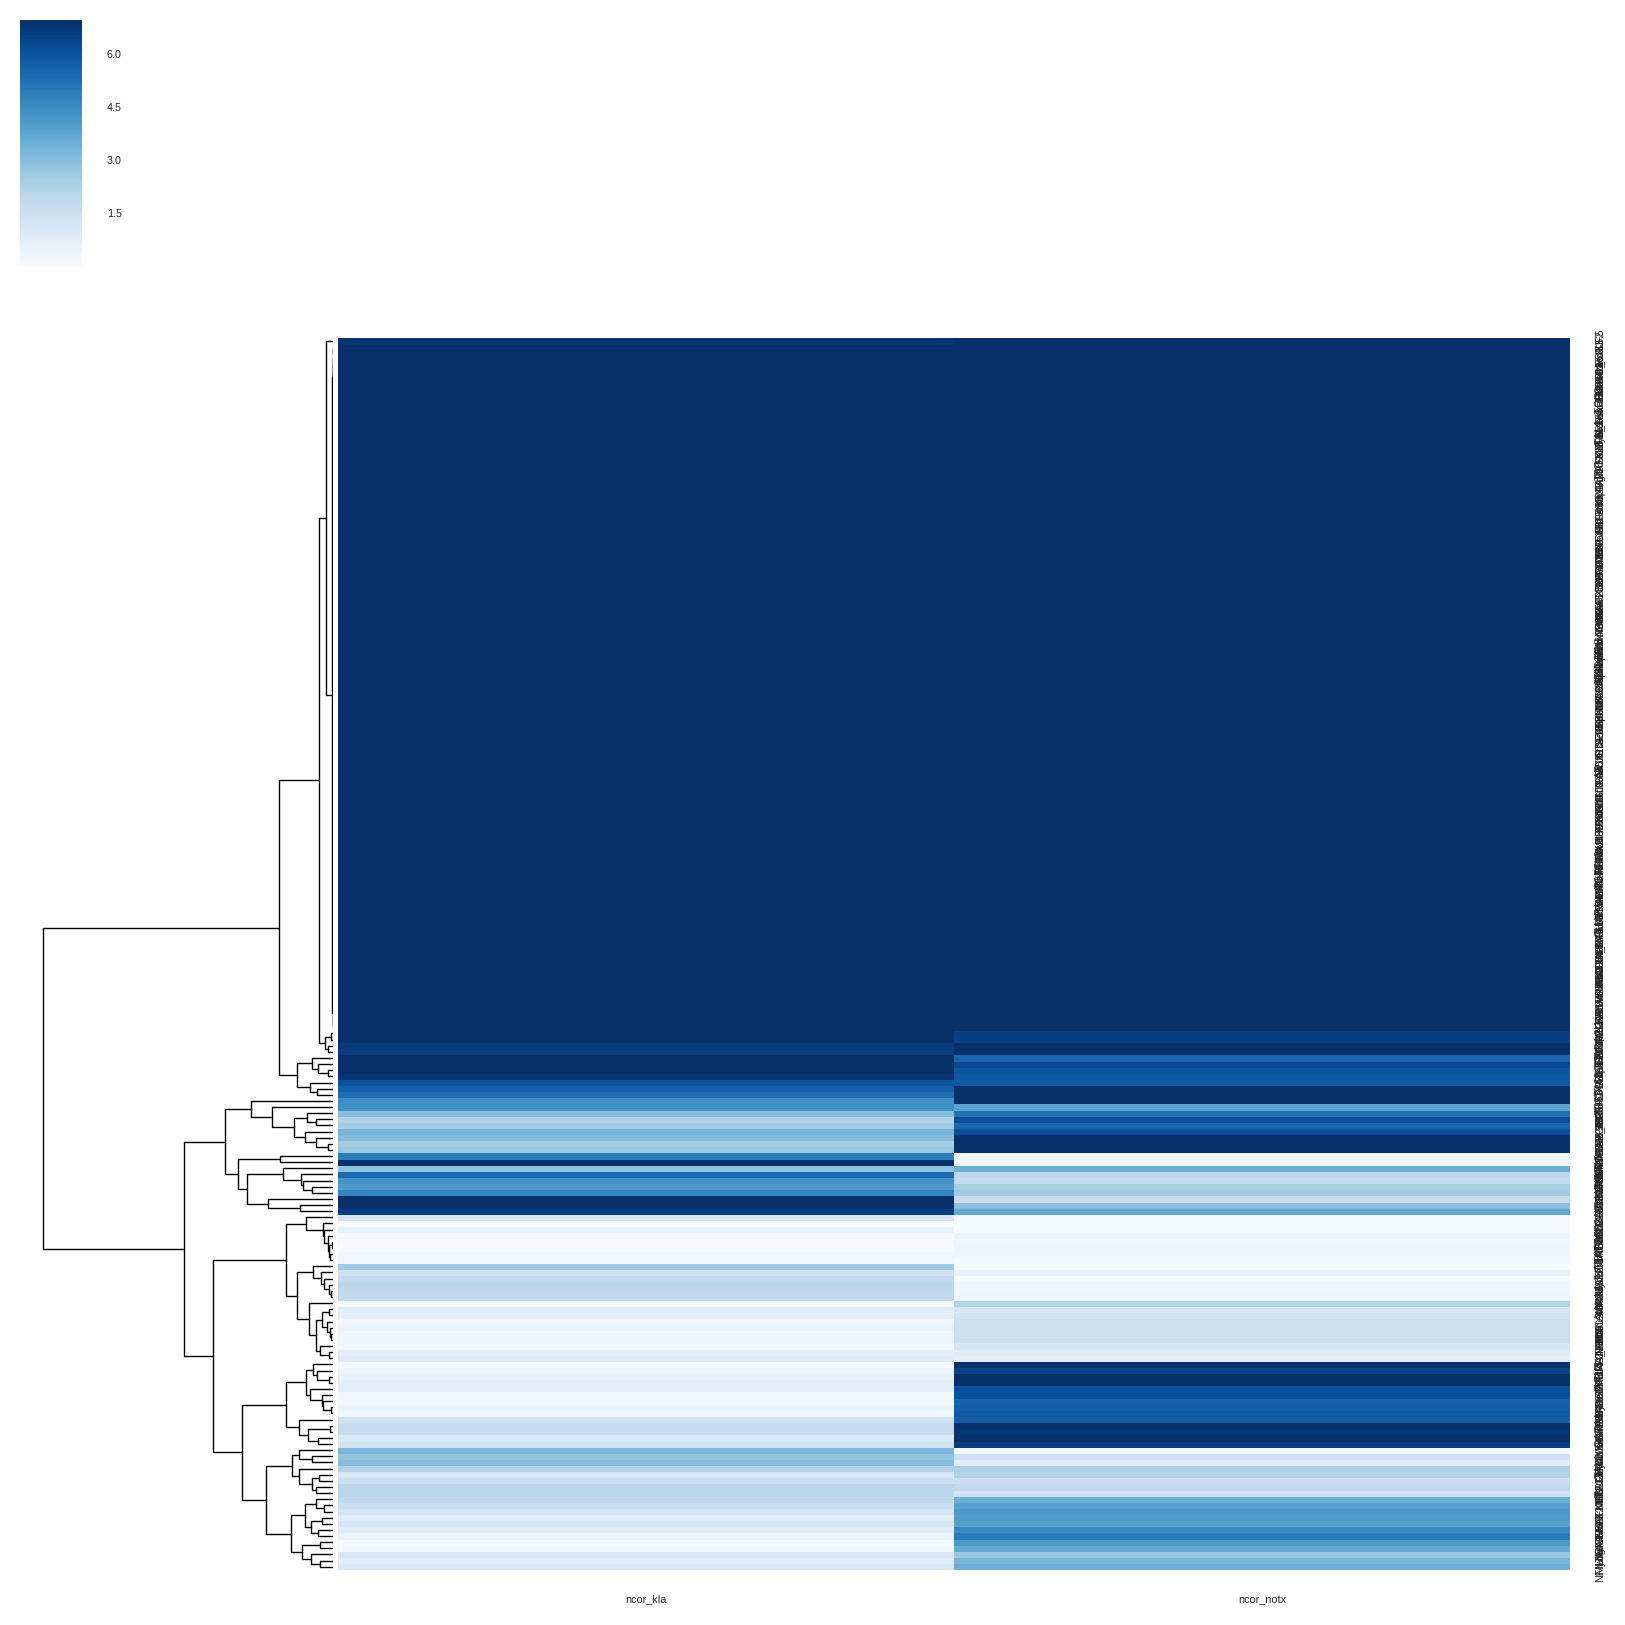

In [161]:
sns.set_context('talk',font_scale=0.3)
sns.clustermap(-1* np.log10(ttest_frame+0.0000001), cmap='Blues', col_cluster=False)
plt.savefig('ttest.pdf')
sns.set_context('talk',font_scale=1.0)



ncor_kla
ncor_notx


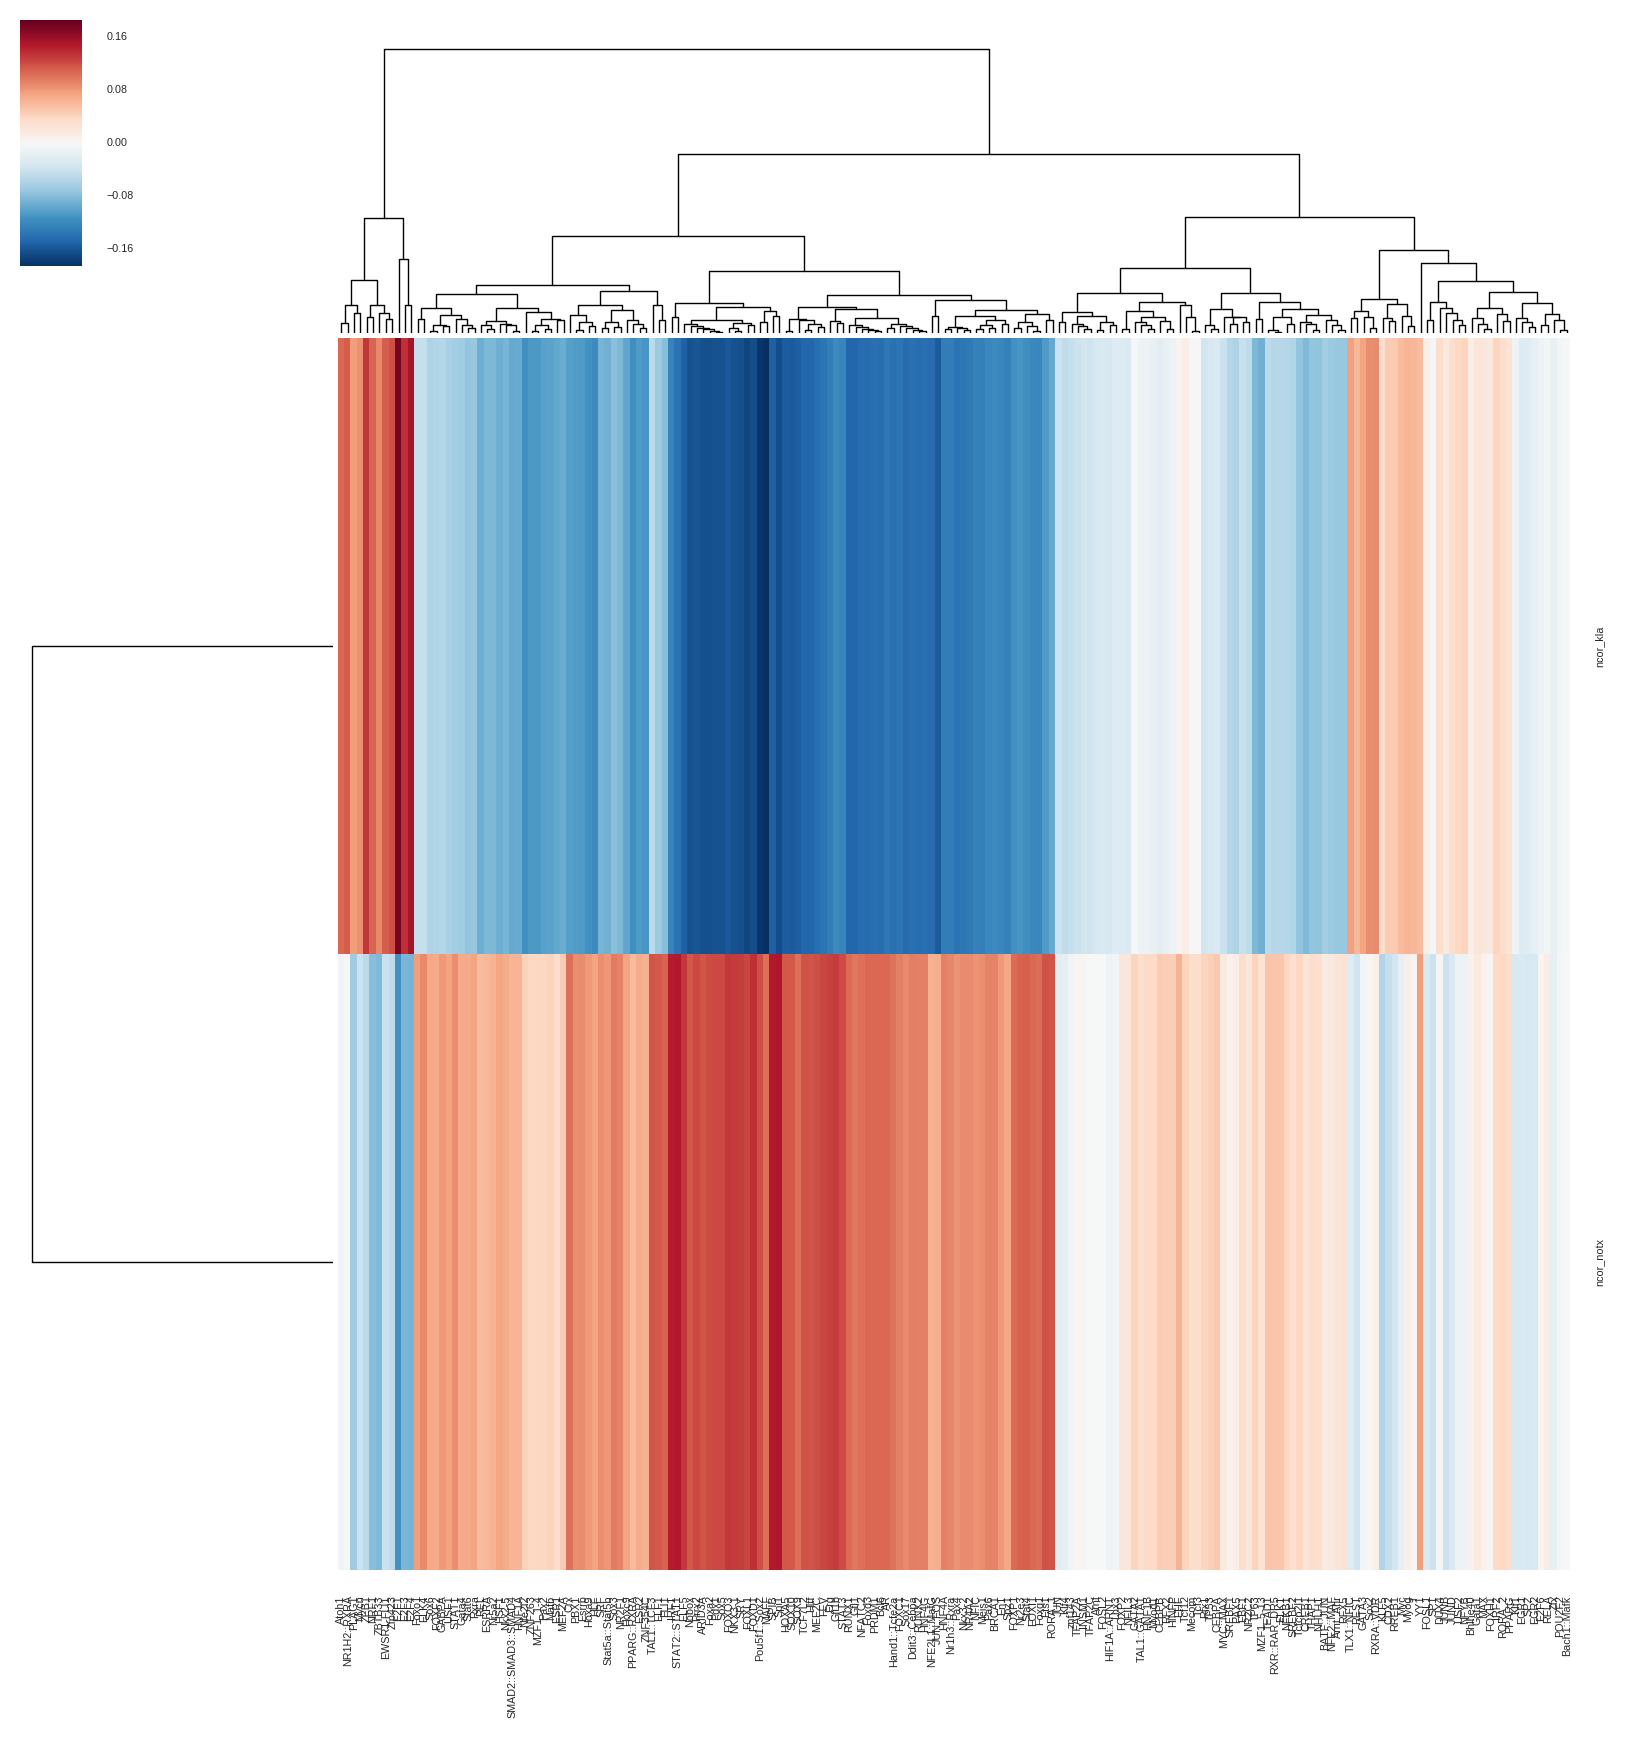

In [170]:
# plot the correlation between motif scores and peak scores
factorTreatments = summary_frame.columns[4:-6].values
motifs = merged_motif_frame.columns[4:-6].values
pearson_matrix = np.zeros((len(factorTreatments), len(motifs)))
spearman_matrix = np.zeros((len(factorTreatments), len(motifs)))
for i in range(len(factorTreatments)):
    ft = factorTreatments[i]
    print(ft)
    for j in range(len(motifs)):
        m = motifs[j]
        peak_scores = summary_frame[ft].values
        motif_scores = merged_motif_frame[m].values
        pearson,  pearson_p_val= scipy.stats.pearsonr(peak_scores, motif_scores)
        spearman, spearman_p_val = scipy.stats.spearmanr(peak_scores, motif_scores)
        pearson_matrix[i][j] = pearson
        spearman_matrix[i][j] = spearman

spearman_frame = pd.DataFrame(spearman_matrix)
spearman_frame.index = factorTreatments
spearman_frame.columns = motifs

pearson_frame = pd.DataFrame(spearman_matrix)
pearson_frame.index = factorTreatments
pearson_frame.columns = motifs

# fill in missing values
# pearson_frame = pearson_frame.fillna(0)
# spearman_frame = spearman_frame.fillna(0)
sns.set_context('talk',font_scale=0.3)
sns.clustermap(spearman_frame)
plt.savefig('spearman_motifScore_peakScore.pdf')
sns.set_context('talk',font_scale=1.0)



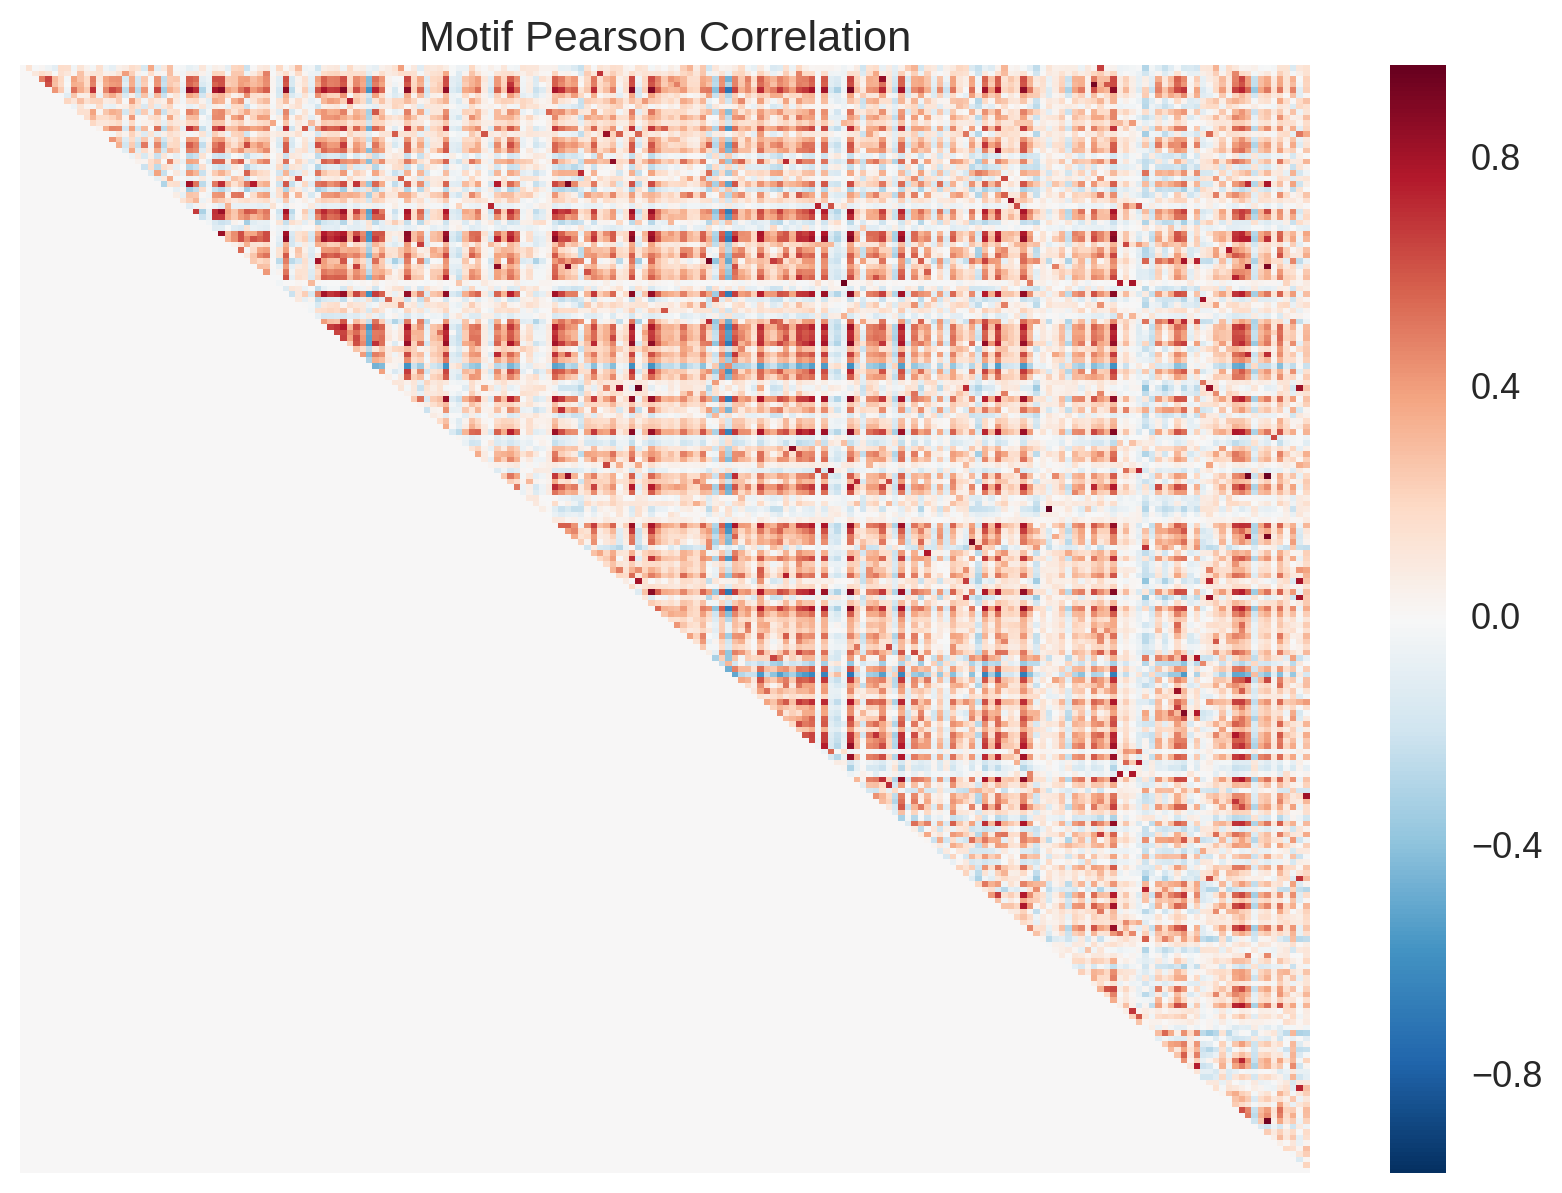

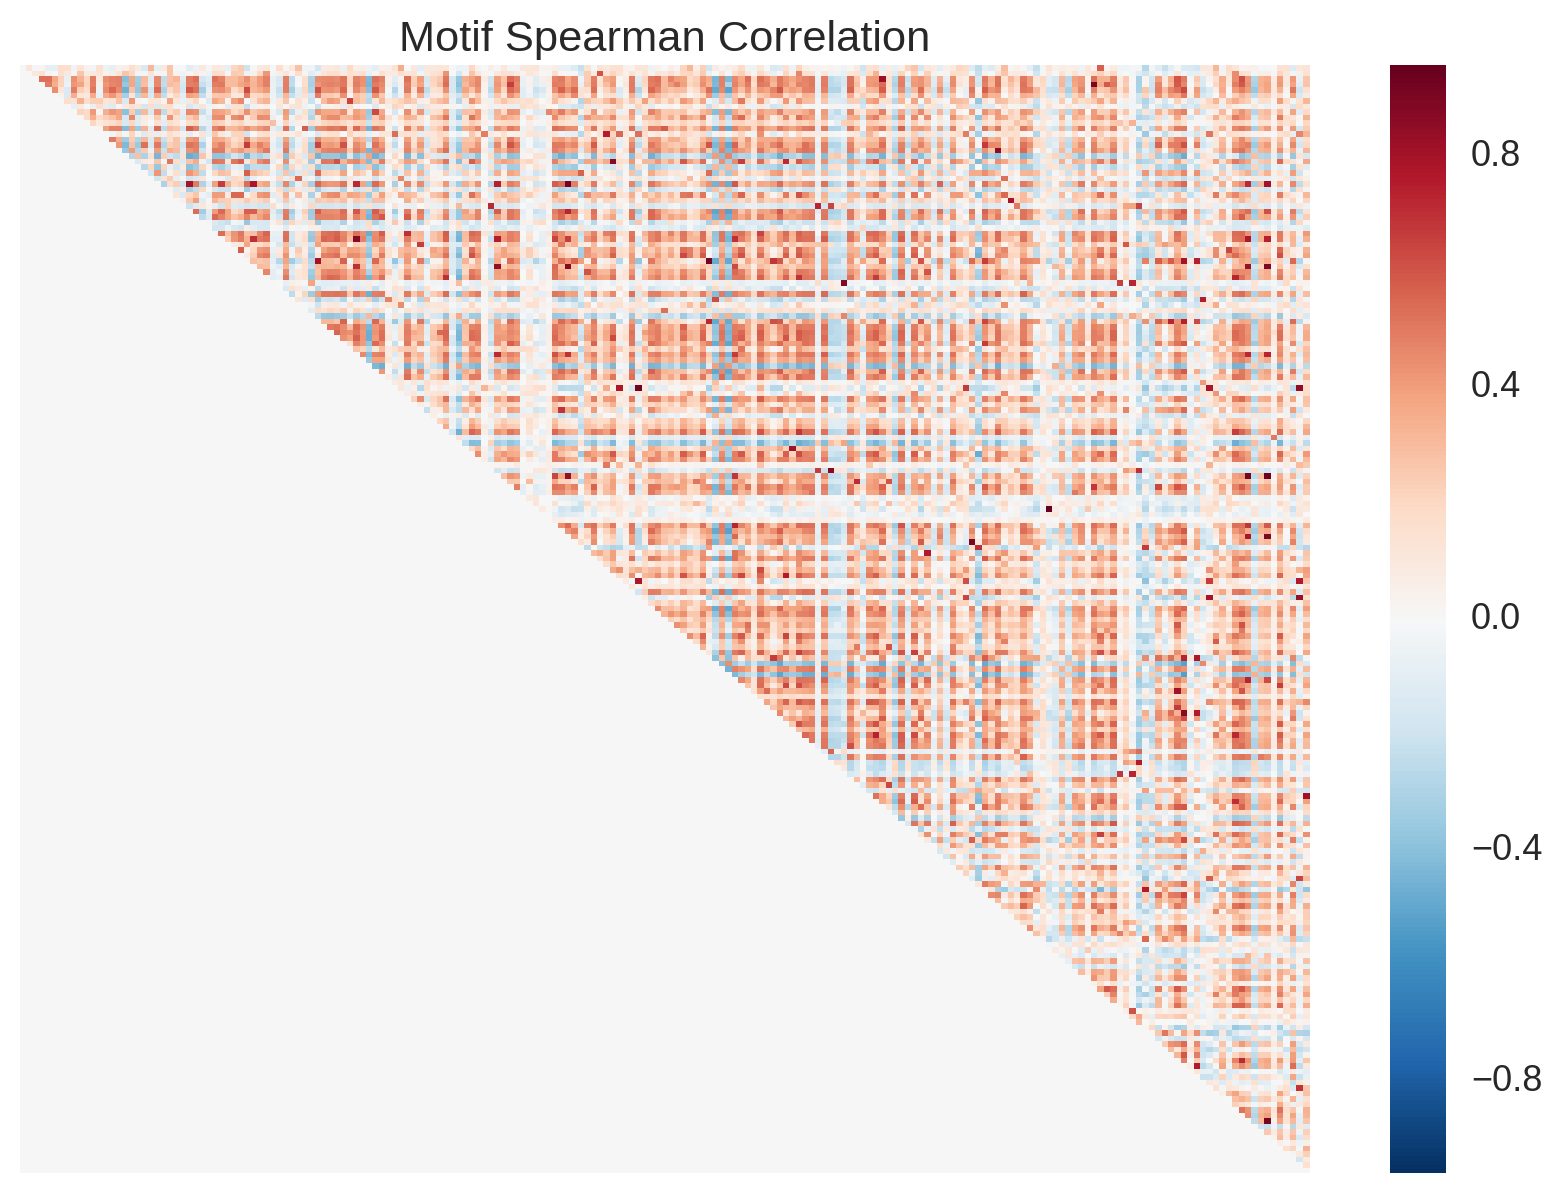

In [174]:
# Show how motif scores correlate to one another
# plot distribution of motif scores
data_dict = {}
count = 0
sort_list = []
motifs = merged_motif_frame.columns[3:]
motif_corr_pearson_matrix = np.zeros((len(motifs), len(motifs)))
motif_corr_spearman_matrix = np.zeros((len(motifs), len(motifs)))
# for every pair of motifs
for i in range(len(motifs) -1 ):
    for j in range(i+1, len(motifs)):
        motif1 = motifs[i]
        motif2 = motifs[j]
        # get relevant motif scores
        motifScores1 = merged_motif_frame[motif1].values
        motifScores2 = merged_motif_frame[motif2].values
        # calculate spearman and peason correlation
        r, p_val_pearson = scipy.stats.pearsonr(motifScores1, motifScores2)
        rho, p_val_spearman = scipy.stats.spearmanr(motifScores1, motifScores2)
        # fill in position in matrix
        motif_corr_pearson_matrix[i][j] = r
        motif_corr_spearman_matrix[i][j] = rho

# create data frames
motif_corr_pearson_frame = pd.DataFrame(motif_corr_pearson_matrix)
motif_corr_spearman_frame = pd.DataFrame(motif_corr_spearman_matrix)

motif_corr_pearson_frame = motif_corr_pearson_frame.fillna(0)
motif_corr_pearson_frame.columns = motifs
motif_corr_pearson_frame.index = motifs

motif_corr_spearman_frame = motif_corr_spearman_frame.fillna(0)
motif_corr_spearman_frame.columns = motifs
motif_corr_spearman_frame.index = motifs

sns.heatmap(motif_corr_pearson_frame,xticklabels = False, yticklabels = False)
plt.title('Motif Pearson Correlation')
plt.show()

sns.heatmap(motif_corr_spearman_frame,xticklabels = False, yticklabels = False)
plt.title('Motif Spearman Correlation')
plt.show()

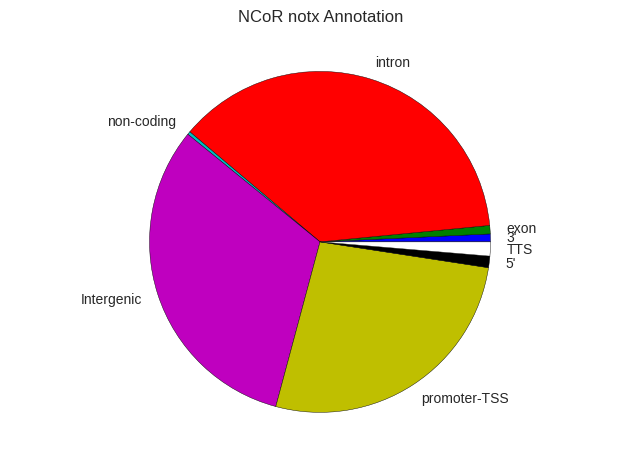

In [272]:
data = pd.read_csv('ncor_peak_categorization/ncor_notx_annotated_peaks.tsv',sep='\t')
data['Annotation'] = [x.split()[0] for x in data['Annotation'].values]
annotationTypes = set(data['Annotation'].values)
sns.set_context('notebook',font_scale=1.0)
plt.axis('equal')
labels = []
counts =  []
annotations = list(data['Annotation'].values)
for ann in annotationTypes:
    labels.append(ann)
    counts.append(annotations.count(ann))
    data[data['Annotation'] == ann].to_csv('./ncor_peak_categorization/ncor_notx_'+ann+'_peaks.tsv', sep='\t', index=False)
plt.pie(counts, labels = labels);
plt.title('NCoR notx Annotation')

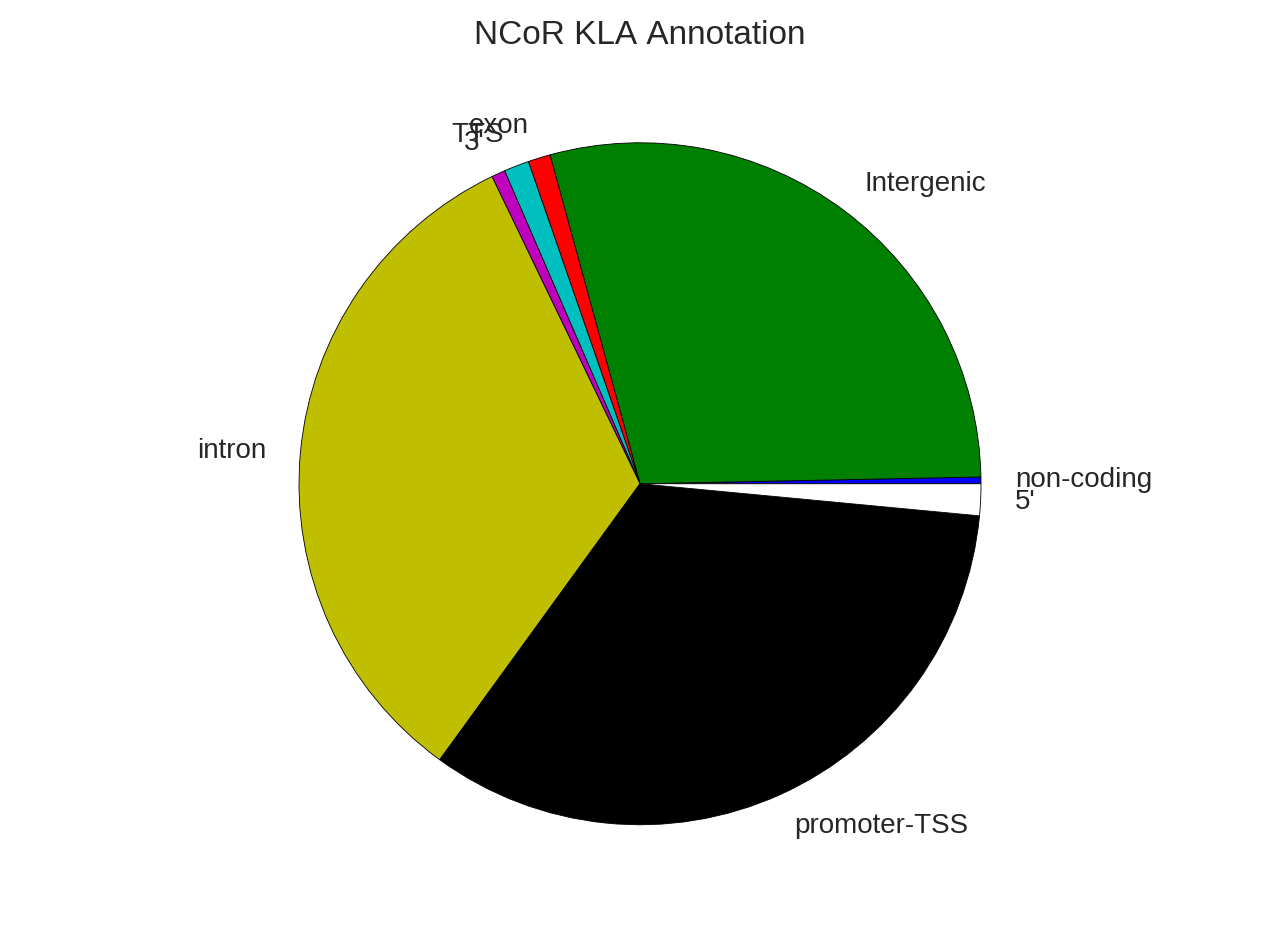

In [33]:
data = pd.read_csv('ncor_peak_categorization/ncor_kla_annotated_peaks.tsv',sep='\t')
data['Annotation'] = [x.split()[0] for x in data['Annotation'].values]
annotationTypes = set(data['Annotation'].values)
sns.set_context('notebook',font_scale=1.0)
plt.axis('equal')
labels = []
counts =  []
annotations = list(data['Annotation'].values)
for ann in annotationTypes:
    labels.append(ann)
    counts.append(annotations.count(ann))
    data[data['Annotation'] == ann].to_csv('./ncor_peak_categorization/ncor_kla_'+ann+'_peaks.tsv', sep='\t', index=False)
plt.pie(counts, labels = labels);
plt.title('NCoR KLA Annotation')

## Work with marks of active enhancers

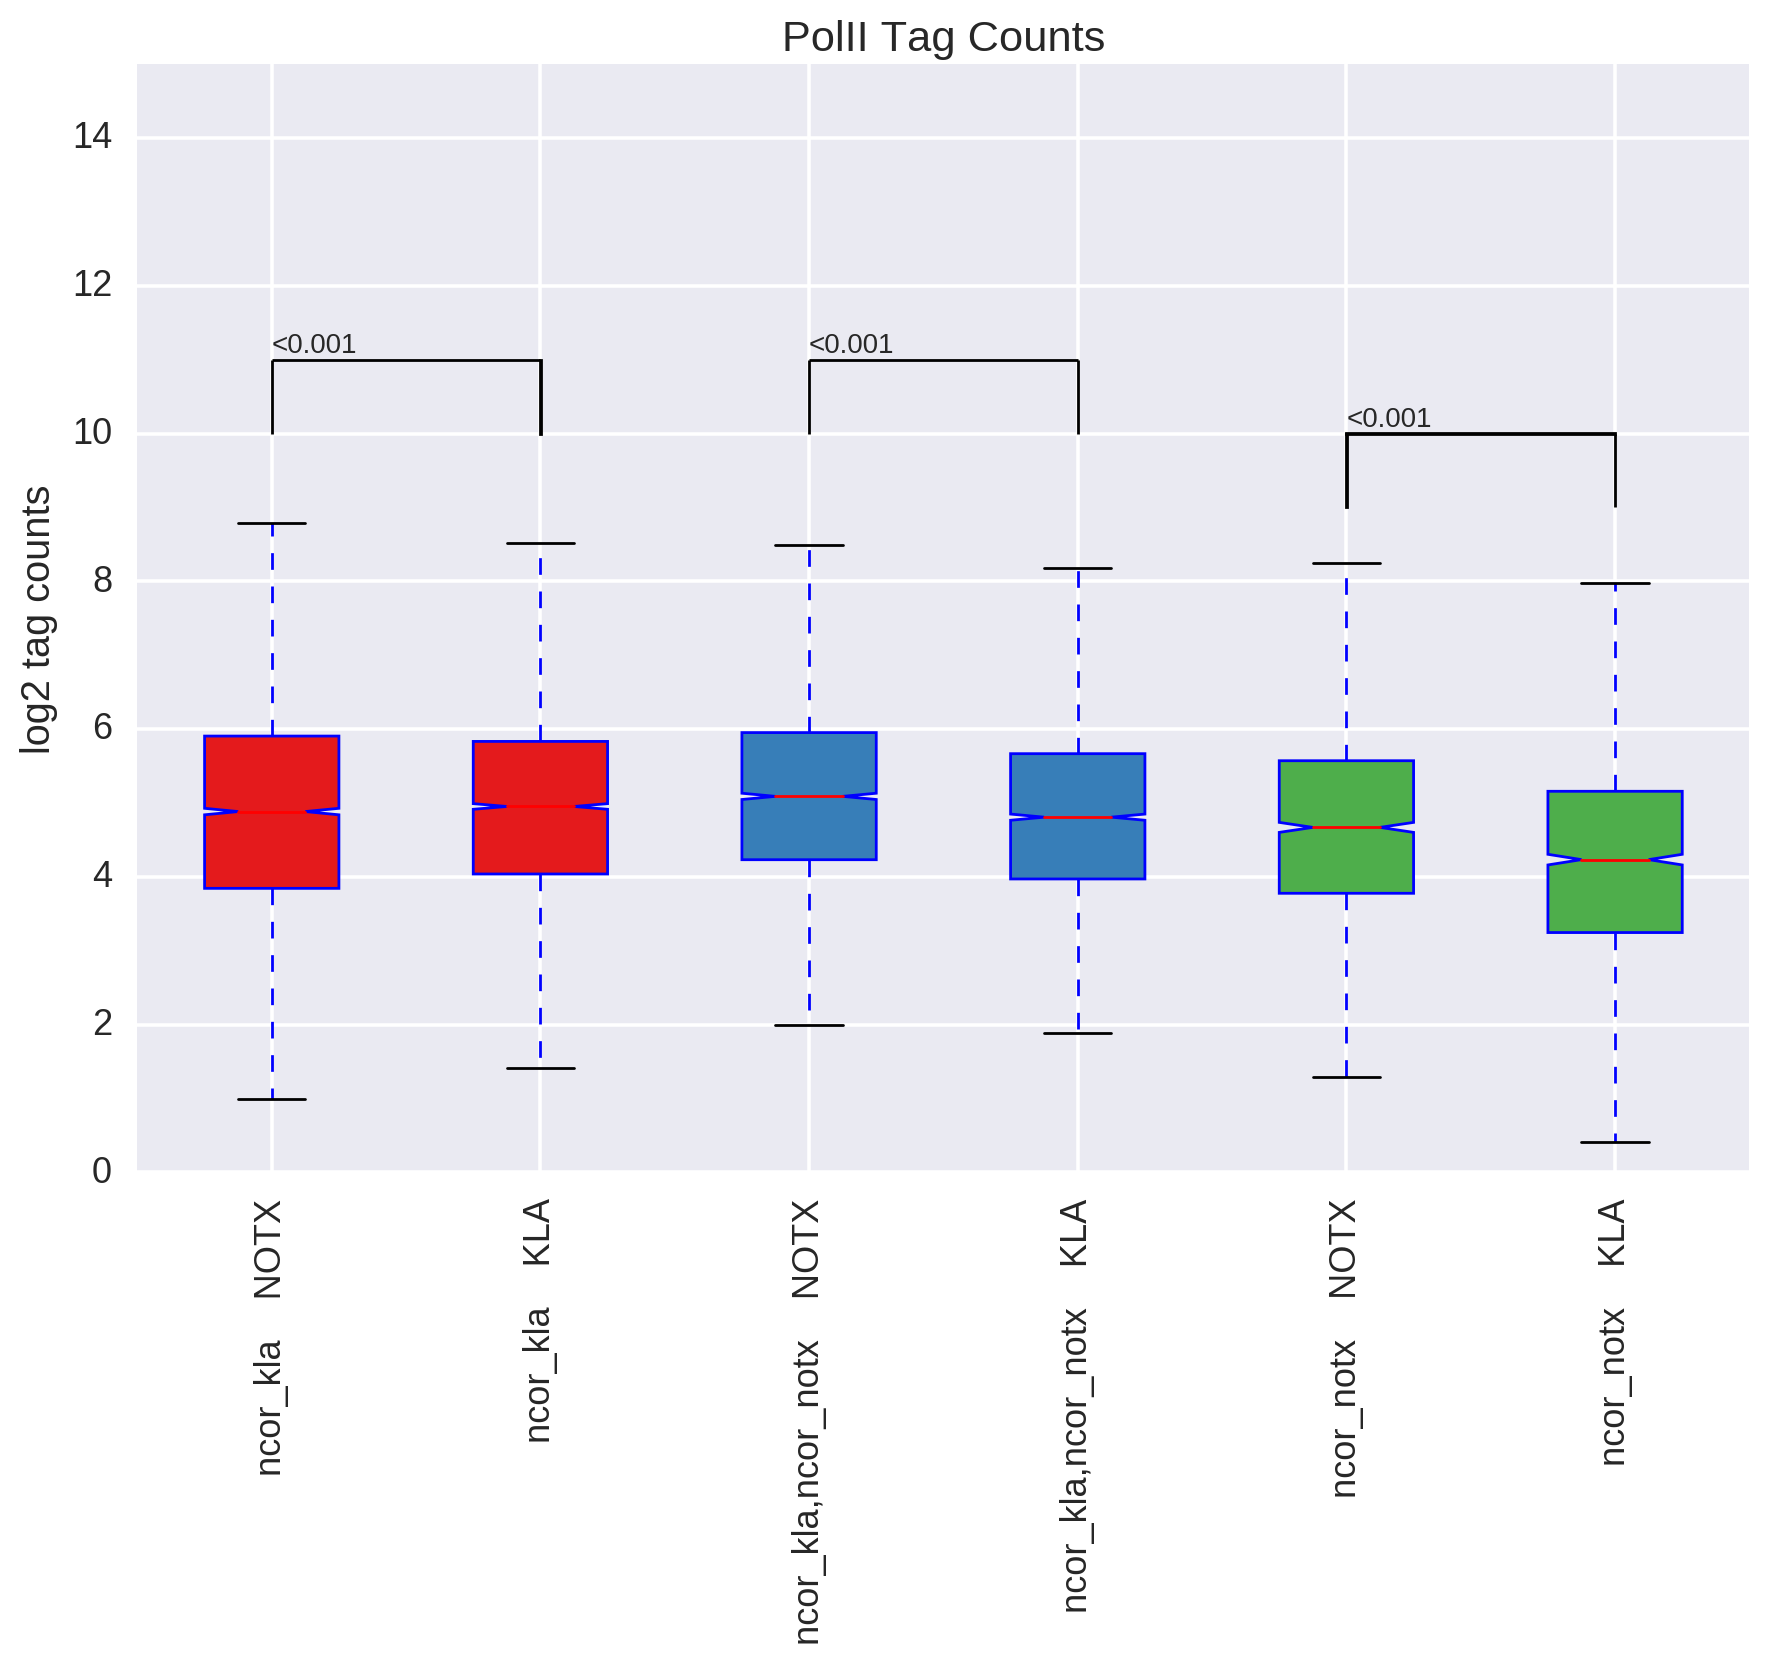

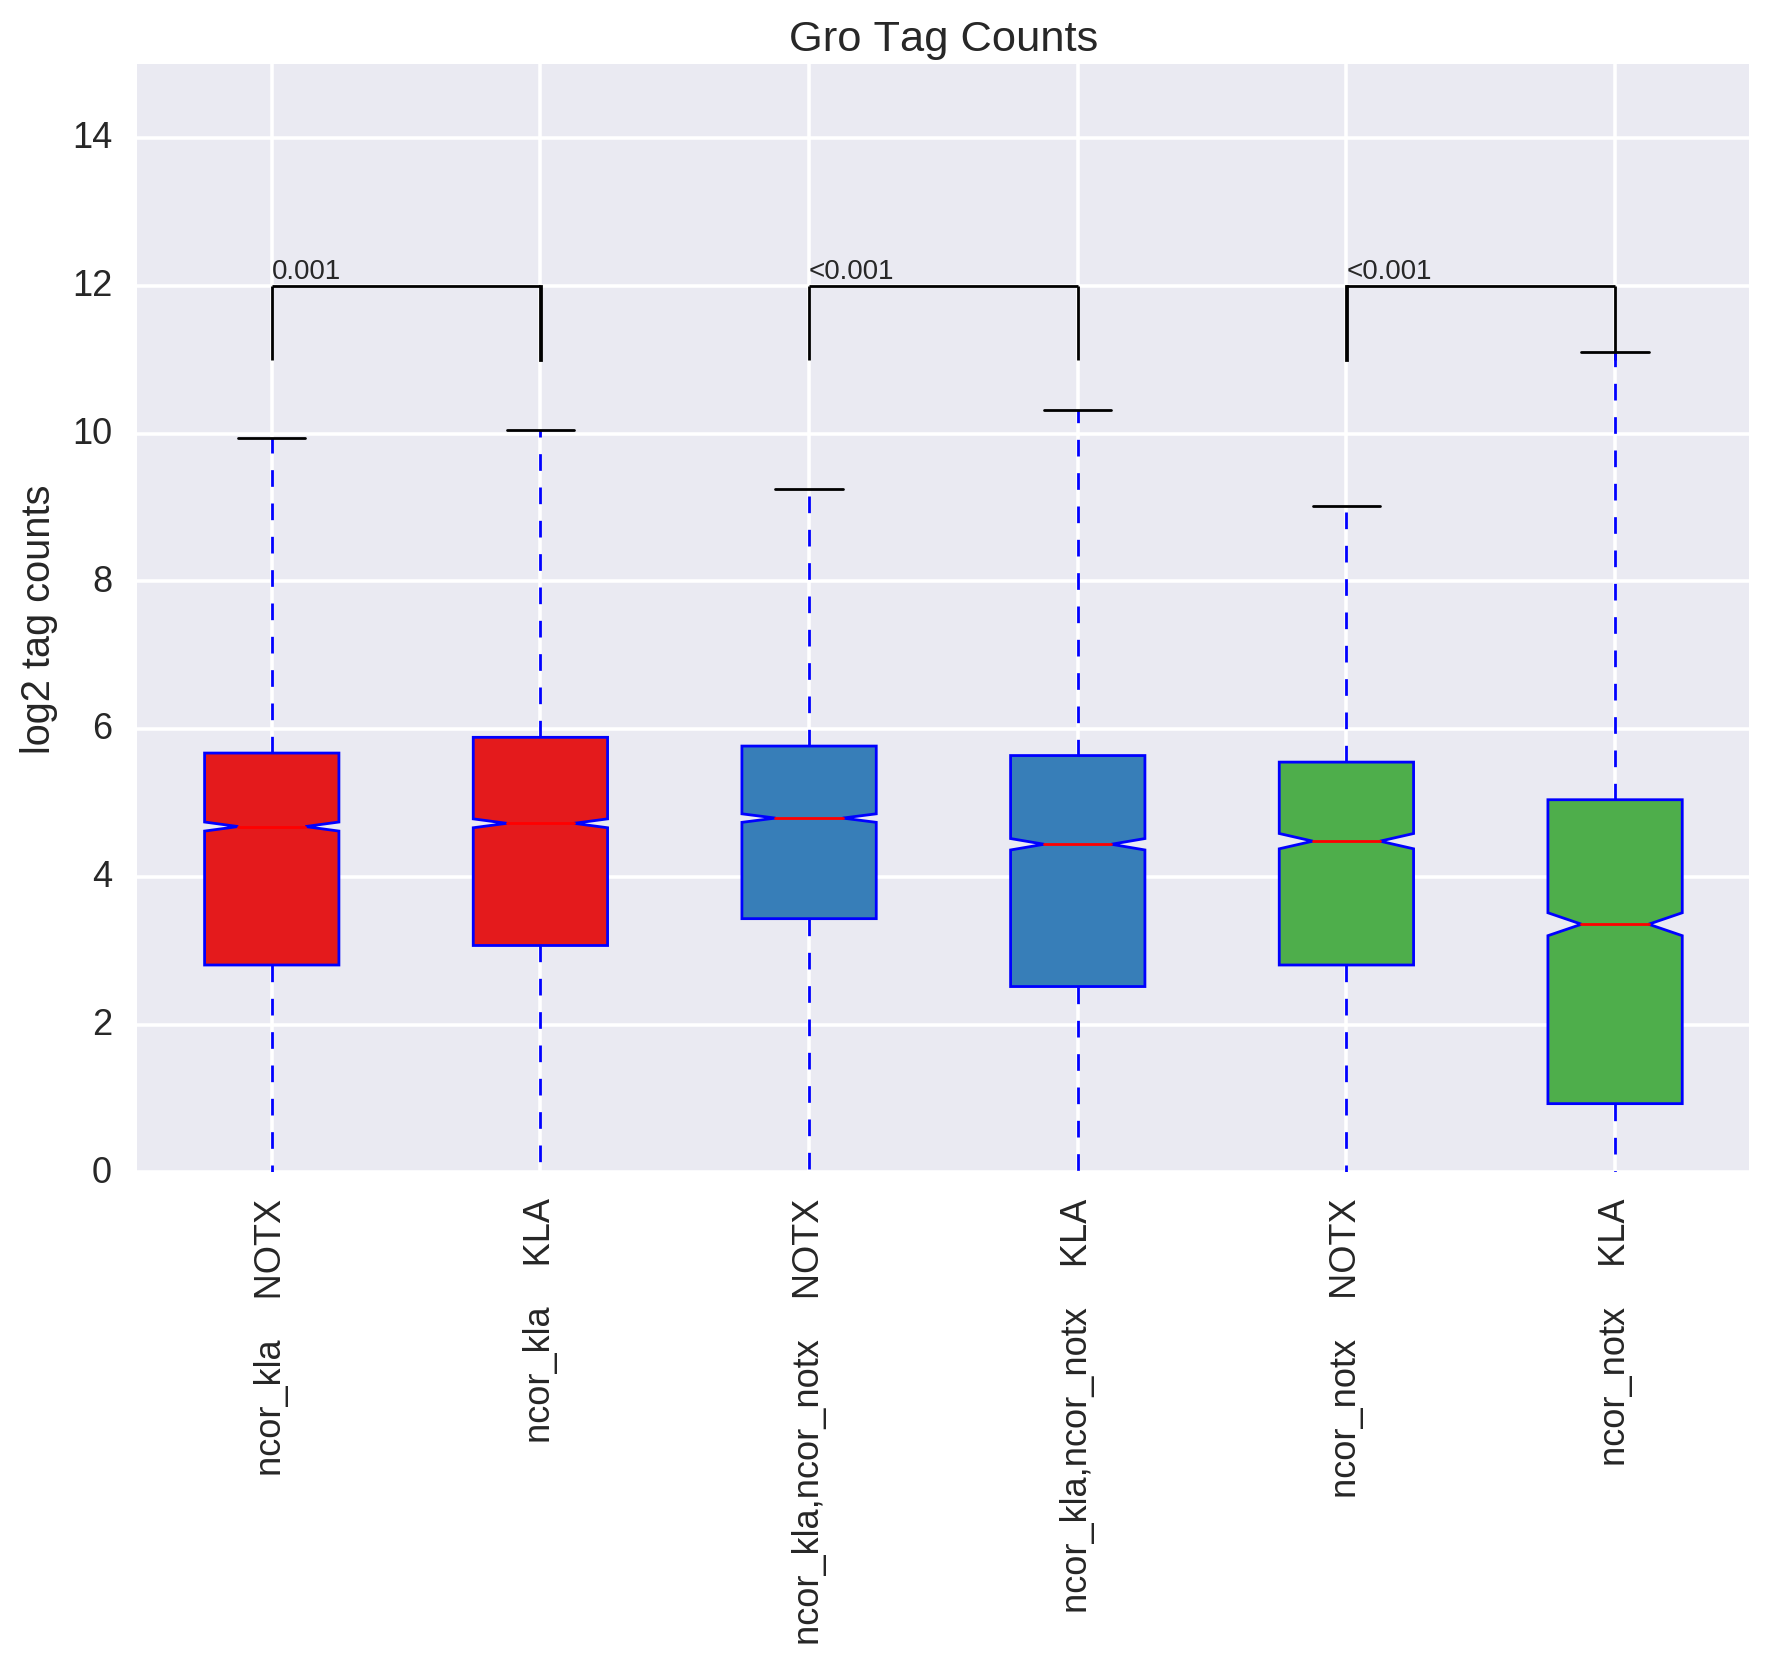

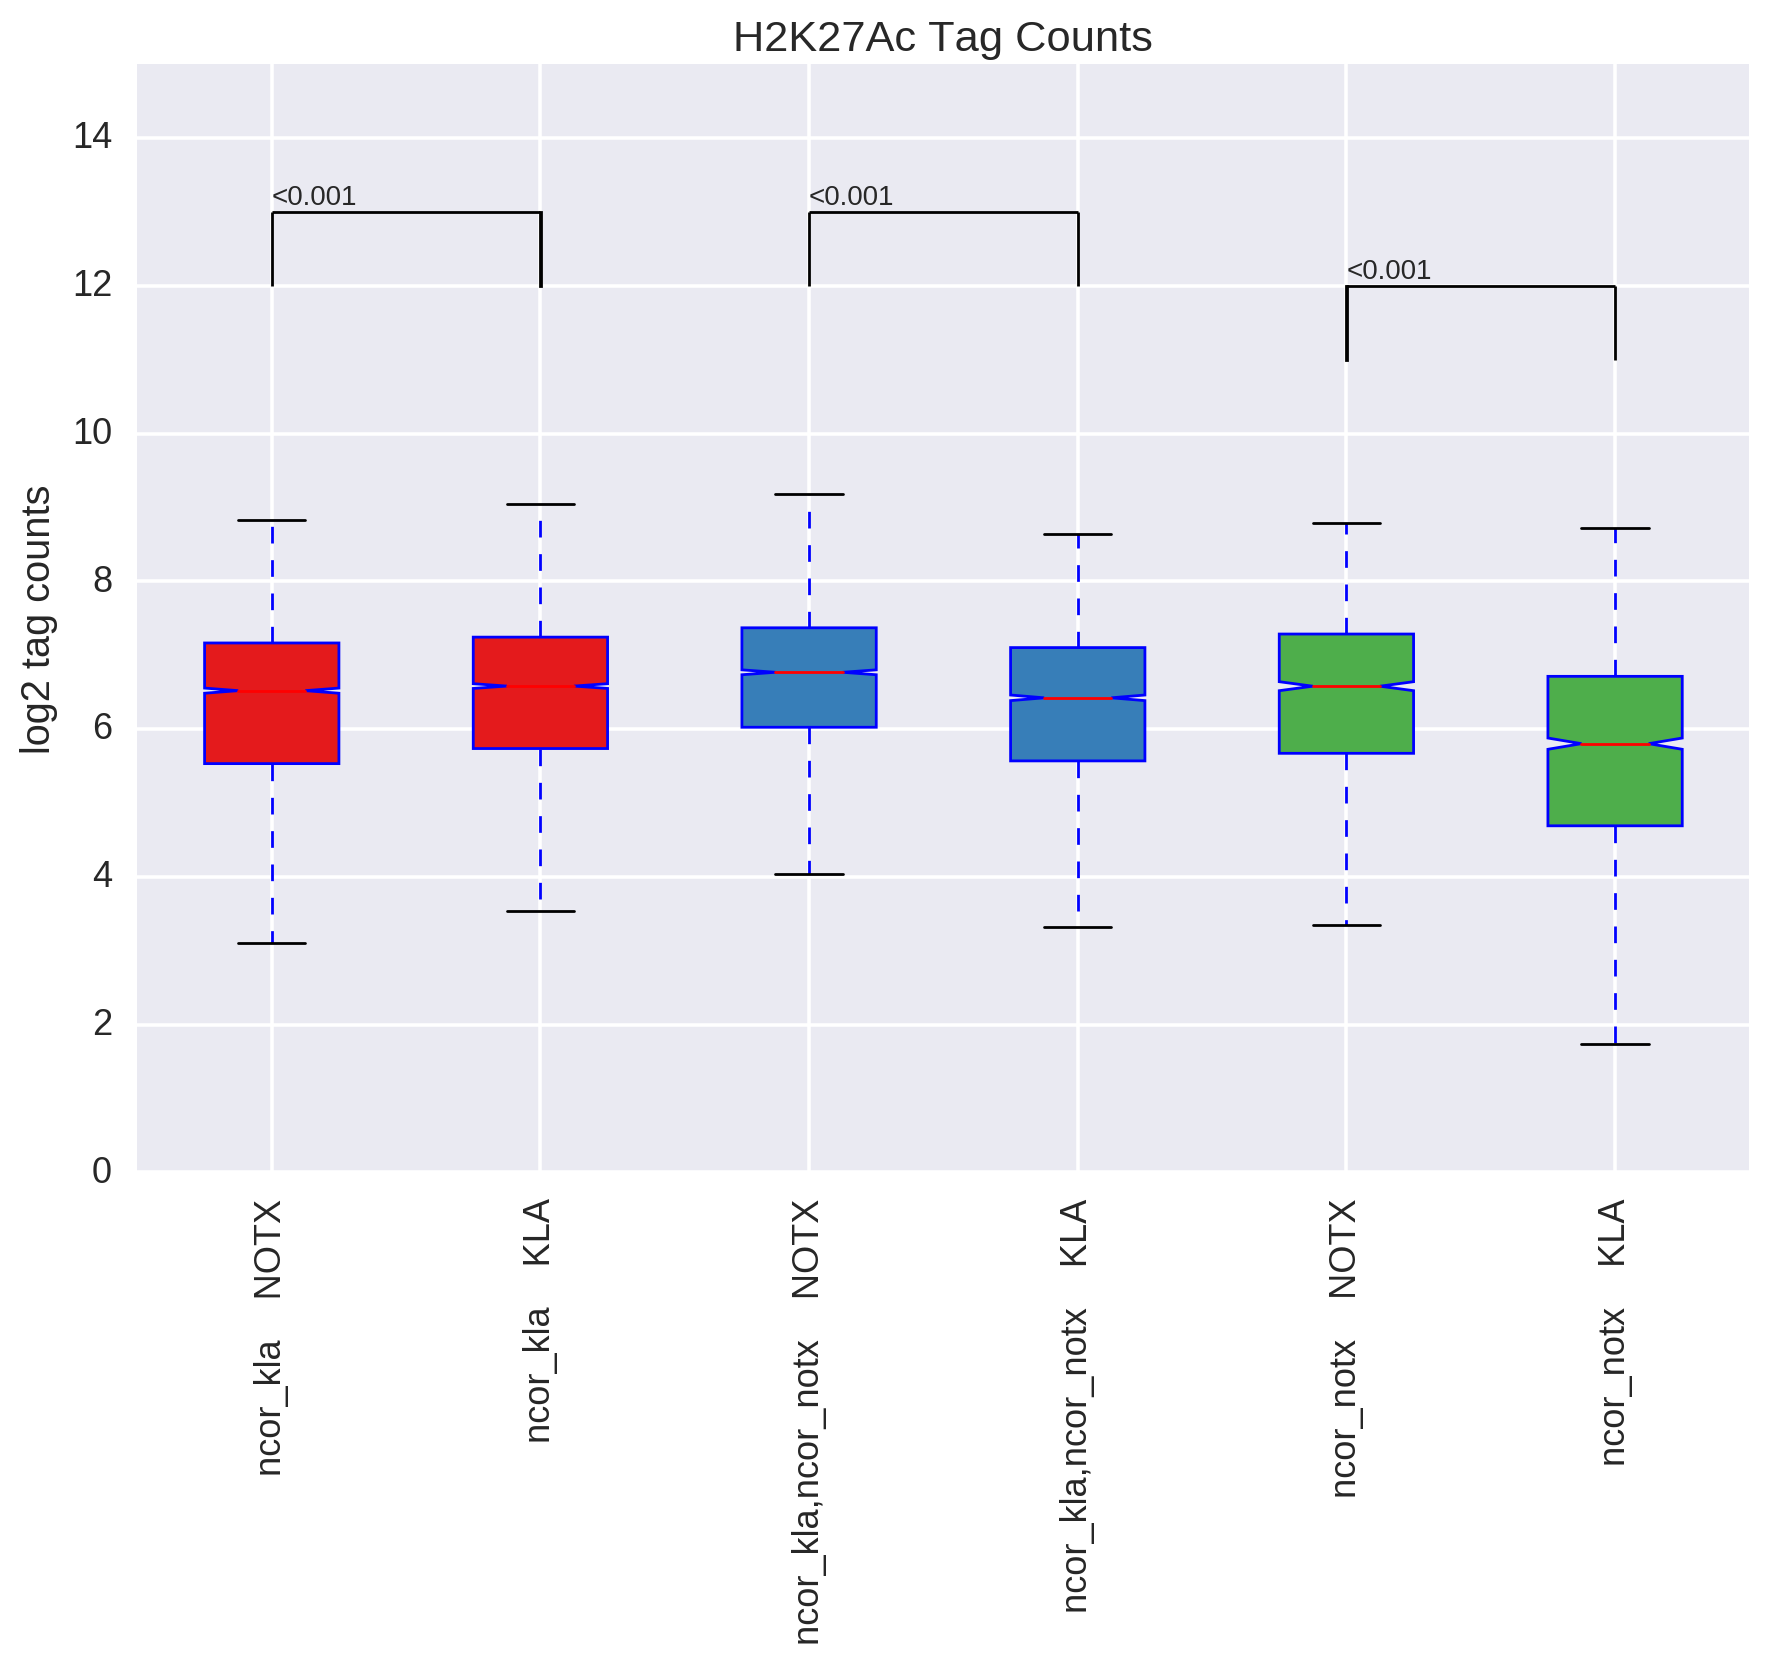

In [20]:
# factor_groups = set(summary_frame['Factors'].values)
numColors = 16
colorDict = dict(zip(range(numColors),sns.color_palette("Set1") + sns.color_palette("Set2") + sns.color_palette("colorblind")))


factor_groups =['ncor_kla',
 'ncor_kla,ncor_notx',
 'ncor_kla,ncor_notx,p65_kla',
 'ncor_kla,p65_kla',
 'ncor_notx',
 'p65_kla',
 ]

colorValues = list(colorDict.values())
colors = []

for i in range(len(factor_groups)):
    colors.append(colorValues[i])
    colors.append(colorValues[i])

p_threshold = 0.05
# for Pol II
counts = []
labels = []
pvals = []

for cluster in factor_groups:
    cluster_name = cluster
    ids = summary_frame[summary_frame['Factors'] == cluster_name].index.values
    notx_values = summary_frame.ix[ids,'PolII-notx'].values
    kla_values = summary_frame.ix[ids,'PolII-KLA'].values
    notx_values = np.log2(notx_values +0.0000001)
    kla_values = np.log2(kla_values +0.0000001)


    if np.sum(notx_values) > 0 or np.sum(kla_values) > 0 :
        labels.append(cluster_name +'    NOTX')
        labels.append(cluster_name +'    KLA')
        stat, p = scipy.stats.ttest_ind(notx_values,kla_values)
        counts.append(notx_values)
        counts.append(kla_values)
        stat, p = scipy.stats.ttest_ind(notx_values,kla_values)
        pvals.append(p)
box = plt.boxplot(counts, notch=True, patch_artist=True);

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
# annotate plot with p_values
ax = plt.gca()
for i in range(len(pvals)):
    p = pvals[i]
    if p < p_threshold: 
        height = int(np.percentile(counts[2*i] + counts[2*i+1], 75))
        ax.arrow(2*i+1, height, 0,-1, linewidth=1.0,head_width=0.0)
        ax.arrow(2*i+2, height, 0,-1, linewidth=1.0,head_width=0.0)
        ax.arrow(2*i+1,height ,1,0, linewidth=1.0,head_width=0.0)
        ax.annotate("{:.3f}".format(p).replace('0.000','<0.001'),xy=(2*i+1,height+0.1))
    
plt.xticks(range(1,len(labels)+1), labels, rotation =90);
plt.ylim([0,15])
plt.ylabel('log2 tag counts')
plt.title('PolII Tag Counts')
plt.show()


# For GRO-seq
counts = []
labels = []
pvals = []

for cluster in factor_groups:
    cluster_name = cluster
    ids = summary_frame[summary_frame['Factors'] == cluster_name].index.values
    notx_values = summary_frame.ix[ids,'Gro-notx'].values
    kla_values = summary_frame.ix[ids,'Gro-KLA'].values
    notx_values = np.log2(notx_values +0.0000001)
    kla_values = np.log2(kla_values +0.0000001)

    if np.sum(notx_values) > 0 or np.sum(kla_values) > 0 :
        labels.append(cluster_name +'    NOTX')
        labels.append(cluster_name +'    KLA')
        stat, p = scipy.stats.ttest_ind(notx_values,kla_values)
        counts.append(notx_values)
        counts.append(kla_values)
        stat, p = scipy.stats.ttest_ind(notx_values,kla_values)
        pvals.append(p)
box = plt.boxplot(counts, notch=True, patch_artist=True);

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
# annotate plot with p_values
ax = plt.gca()
for i in range(len(pvals)):
    p = pvals[i]
    if p < p_threshold: 
        height = int(np.percentile(counts[2*i] + counts[2*i+1], 90))
        ax.arrow(2*i+1, height, 0,-1, linewidth=1.0,head_width=0.0)
        ax.arrow(2*i+2, height, 0,-1, linewidth=1.0,head_width=0.0)
        ax.arrow(2*i+1,height ,1,0, linewidth=1.0,head_width=0.0)
        ax.annotate("{:.3f}".format(p).replace('0.000','<0.001'),xy=(2*i+1,height+0.1))
        
plt.xticks(range(1,len(labels)+1), labels, rotation =90);
plt.ylabel('log2 tag counts')
plt.title('Gro Tag Counts')
plt.ylim([0,15])
plt.show()

# For H3K27Ac
counts = []
labels = []
pvals = []
for cluster in factor_groups:
    cluster_name = cluster
    ids = summary_frame[summary_frame['Factors'] == cluster_name].index.values
    notx_values = summary_frame.ix[ids,'H3K27Ac-notx'].values
    kla_values = summary_frame.ix[ids,'H3K27Ac-KLA'].values
    notx_values = np.log2(notx_values +0.0000001)
    kla_values = np.log2(kla_values +0.0000001)

    if np.sum(notx_values) > 0 or np.sum(kla_values) > 0 :
        labels.append(cluster_name +'    NOTX')
        labels.append(cluster_name +'    KLA')
        stat, p = scipy.stats.ttest_ind(notx_values,kla_values)
        counts.append(notx_values)
        counts.append(kla_values)
        stat, p = scipy.stats.ttest_ind(notx_values,kla_values)
        pvals.append(p)
box = plt.boxplot(counts, notch=True, patch_artist=True);

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
# annotate plot with p_values
ax = plt.gca()
for i in range(len(pvals)):
    p = pvals[i]
    if p < p_threshold: 
        height = int(np.percentile(counts[2*i] + counts[2*i+1], 50))
        ax.arrow(2*i+1, height, 0,-1, linewidth=1.0,head_width=0.0)
        ax.arrow(2*i+2, height, 0,-1, linewidth=1.0,head_width=0.0)
        ax.arrow(2*i+1,height ,1,0, linewidth=1.0,head_width=0.0)
        ax.annotate("{:.3f}".format(p).replace('0.000','<0.001'),xy=(2*i+1,height+0.1))
plt.xticks(range(1,len(labels)+1), labels, rotation =90);
plt.ylim([0,15])
plt.ylabel('log2 tag counts')
plt.title('H2K27Ac Tag Counts')
plt.ylim([0,15])
plt.show()

In [30]:

# calculate the difference before and after KLA treatment
difference_frame = summary_frame[['ID', 'chr', 'ncor_notx', 'ncor_kla']]
difference_frame = difference_frame[difference_frame.sum(axis=1) > 0]
difference_frame['Gro_difference'] = summary_frame['Gro-KLA'] - summary_frame['Gro-notx']
difference_frame['PolII_difference'] = summary_frame['PolII-KLA'] - summary_frame['PolII-notx']
difference_frame['H3K27Ac_difference'] = summary_frame['H3K27Ac-KLA'] - summary_frame['H3K27Ac-notx']

# difference_frame = difference_frame[difference_frame['chr']=='chr1']
for col in difference_frame.columns[4:]:
    difference_frame[col] = [np.log2(x+1) if x > 0 else -1 * np.log2(-1*x +1) for x in difference_frame[col].values]

notx_difference_frame = difference_frame[(difference_frame['ncor_notx'] > 0) & (difference_frame['ncor_kla'] == 0)]
kla_difference_frame = difference_frame[(difference_frame['ncor_notx'] == 0) & (difference_frame['ncor_kla'] > 0)]
shared_difference_frame = difference_frame[(difference_frame['ncor_notx'] > 0) & (difference_frame['ncor_kla'] > 0)]

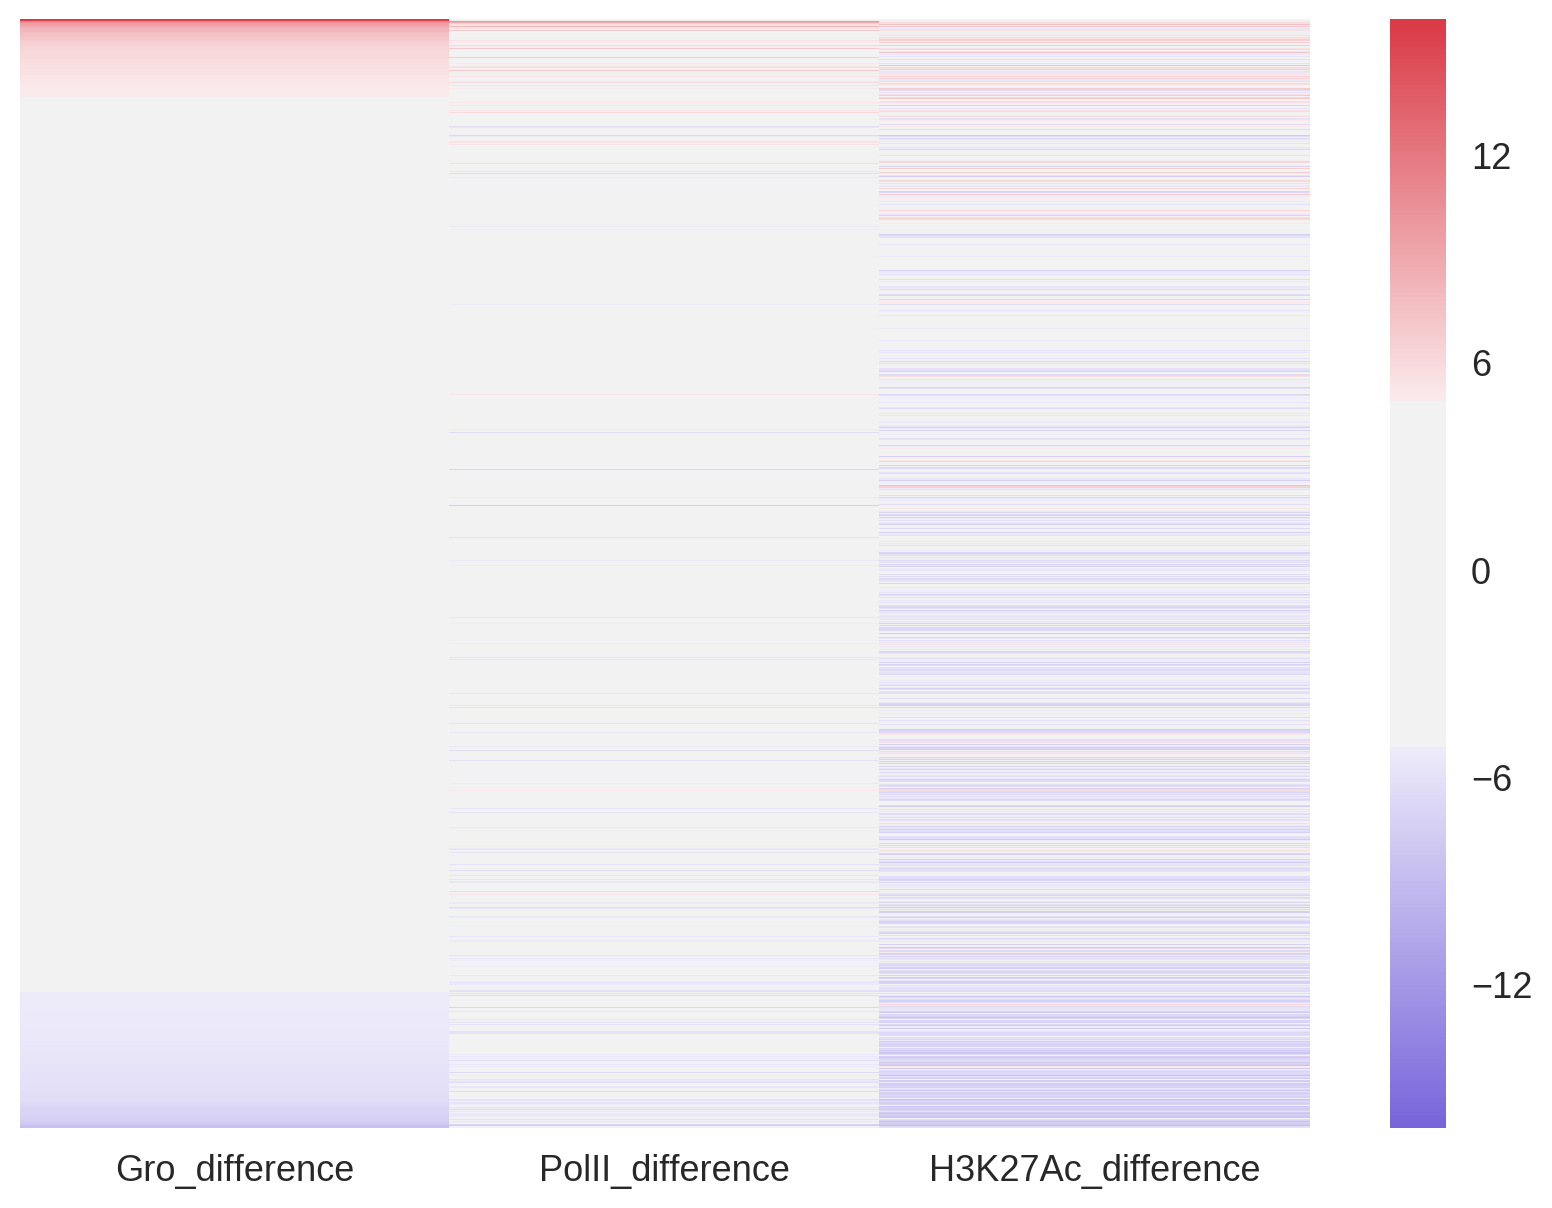

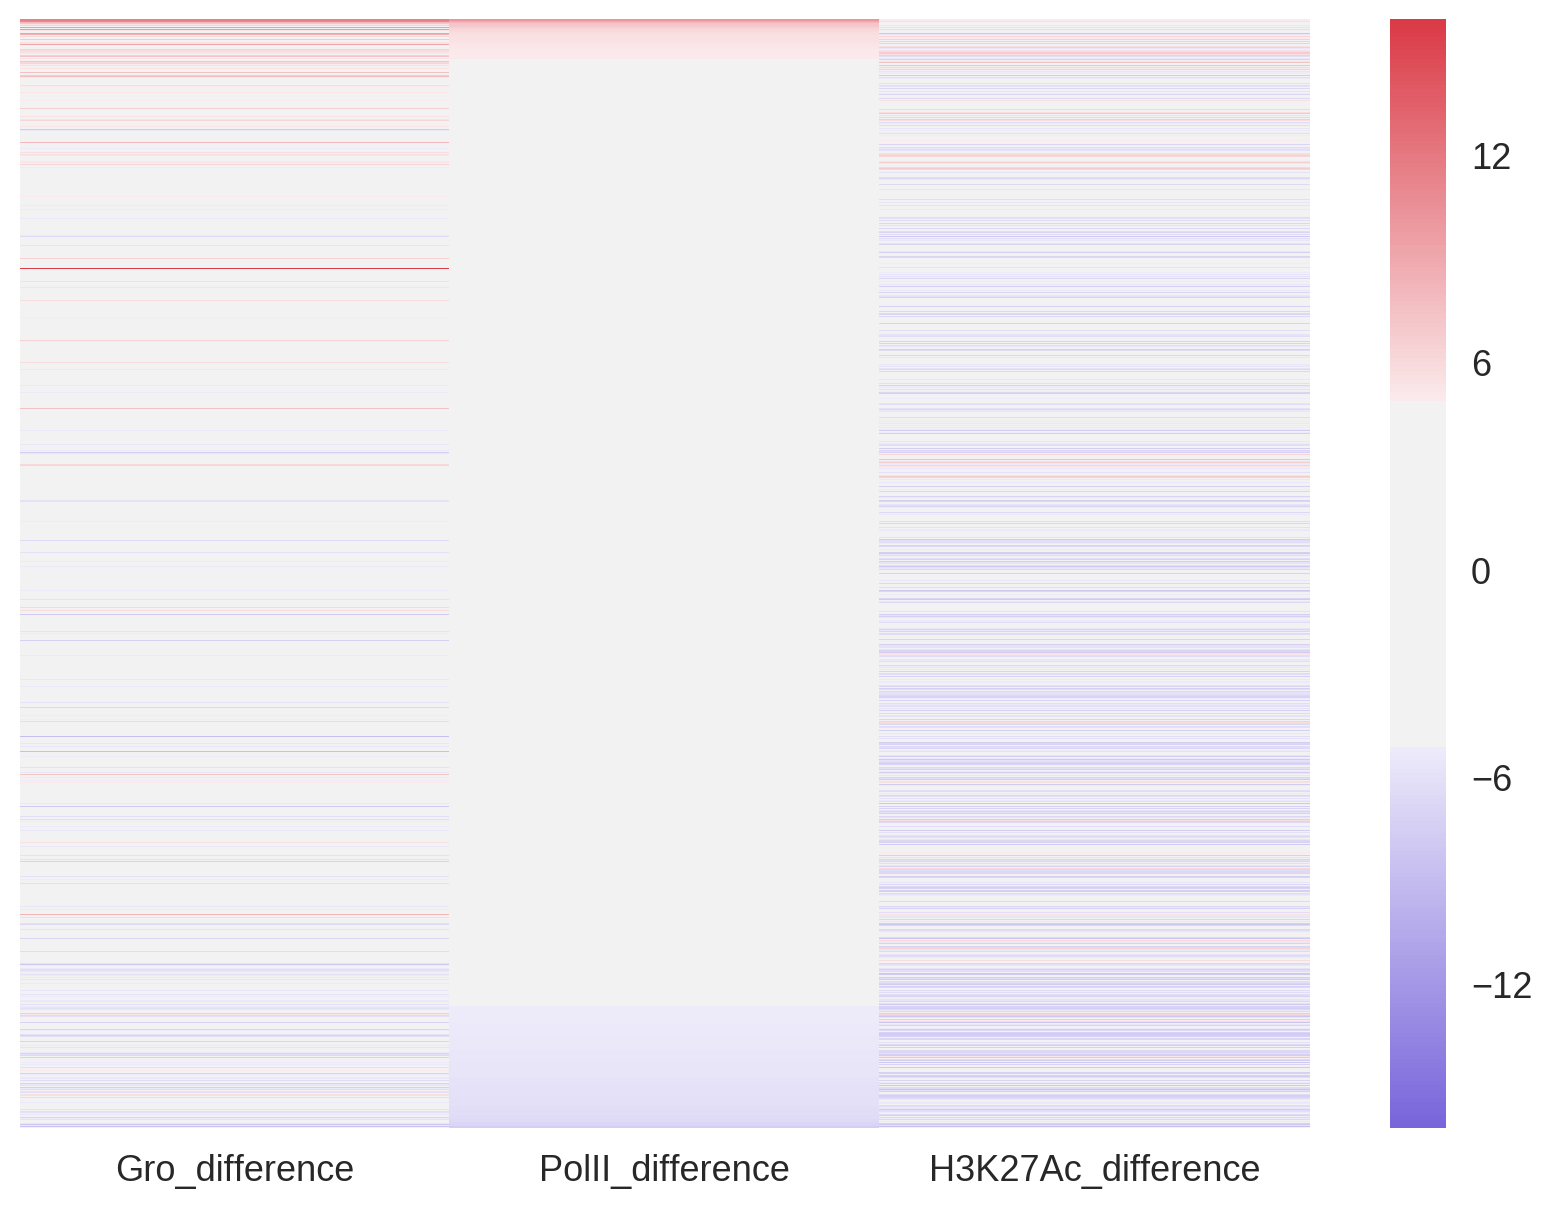

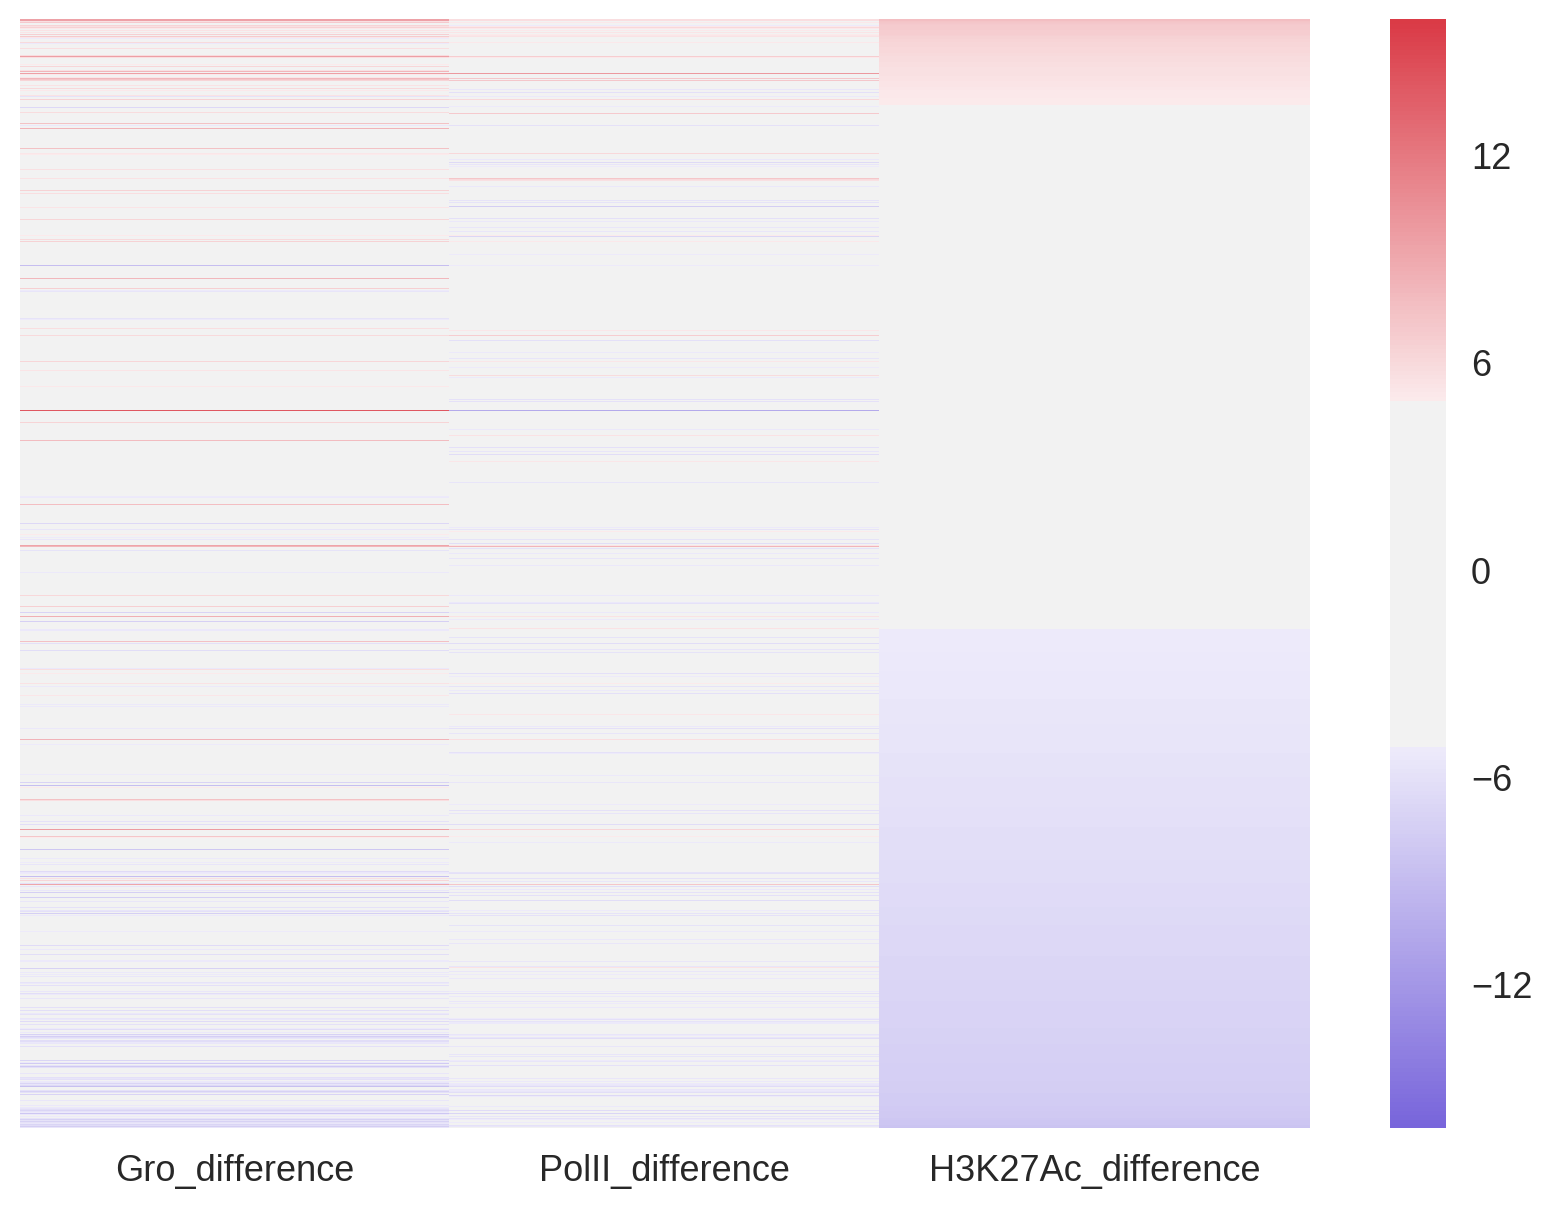

In [32]:
separation = 80

sns.heatmap(notx_difference_frame.sort(['Gro_difference'], 
                                       ascending=False).ix[:,-3:], yticklabels=False, 
                                       cmap=sns.diverging_palette(270, 10, sep=separation, as_cmap=True)
           )
plt.show()
sns.heatmap(notx_difference_frame.sort(['PolII_difference',], 
                                       ascending=False).ix[:,-3:], yticklabels=False, 
                                       cmap=sns.diverging_palette(270, 10, sep=separation, as_cmap=True)
           )
plt.show()


sns.heatmap(notx_difference_frame.sort(['H3K27Ac_difference'], 
                                       ascending=False).ix[:,-3:], yticklabels=False, 
                                       cmap=sns.diverging_palette(270, 10, sep=separation, as_cmap=True)
           )
plt.show()



In [ ]:
### for notx peaks
separation=50
numRowClusters = 4
data = notx_difference_frame.ix[:,-3:]

cg_notx = sns.clustermap(data,col_cluster=False, yticklabels=False, cmap='Greys')
plt.close()

cg_pickle_file = open('cg_notx.pickle','wb')
pickle.dump(cg_notx,cg_pickle_file)
cg_pickle_file.close()

### for KLA peaks
data = kla_difference_frame.ix[:,-3:]

cg_kla = sns.clustermap(data,col_cluster=False, yticklabels=False, cmap='Greys')
plt.close()

cg_pickle_file = open('cg_kla.pickle','wb')
pickle.dump(cg_kla,cg_pickle_file)
cg_pickle_file.close()

### for shared peaks
data = shared_difference_frame.ix[:,-3:]

cg_shared = sns.clustermap(data,col_cluster=False, yticklabels=False, cmap='Greys')
plt.close()

cg_pickle_file = open('cg_shared.pickle','wb')
pickle.dump(cg_shared,cg_pickle_file)
cg_pickle_file.close()

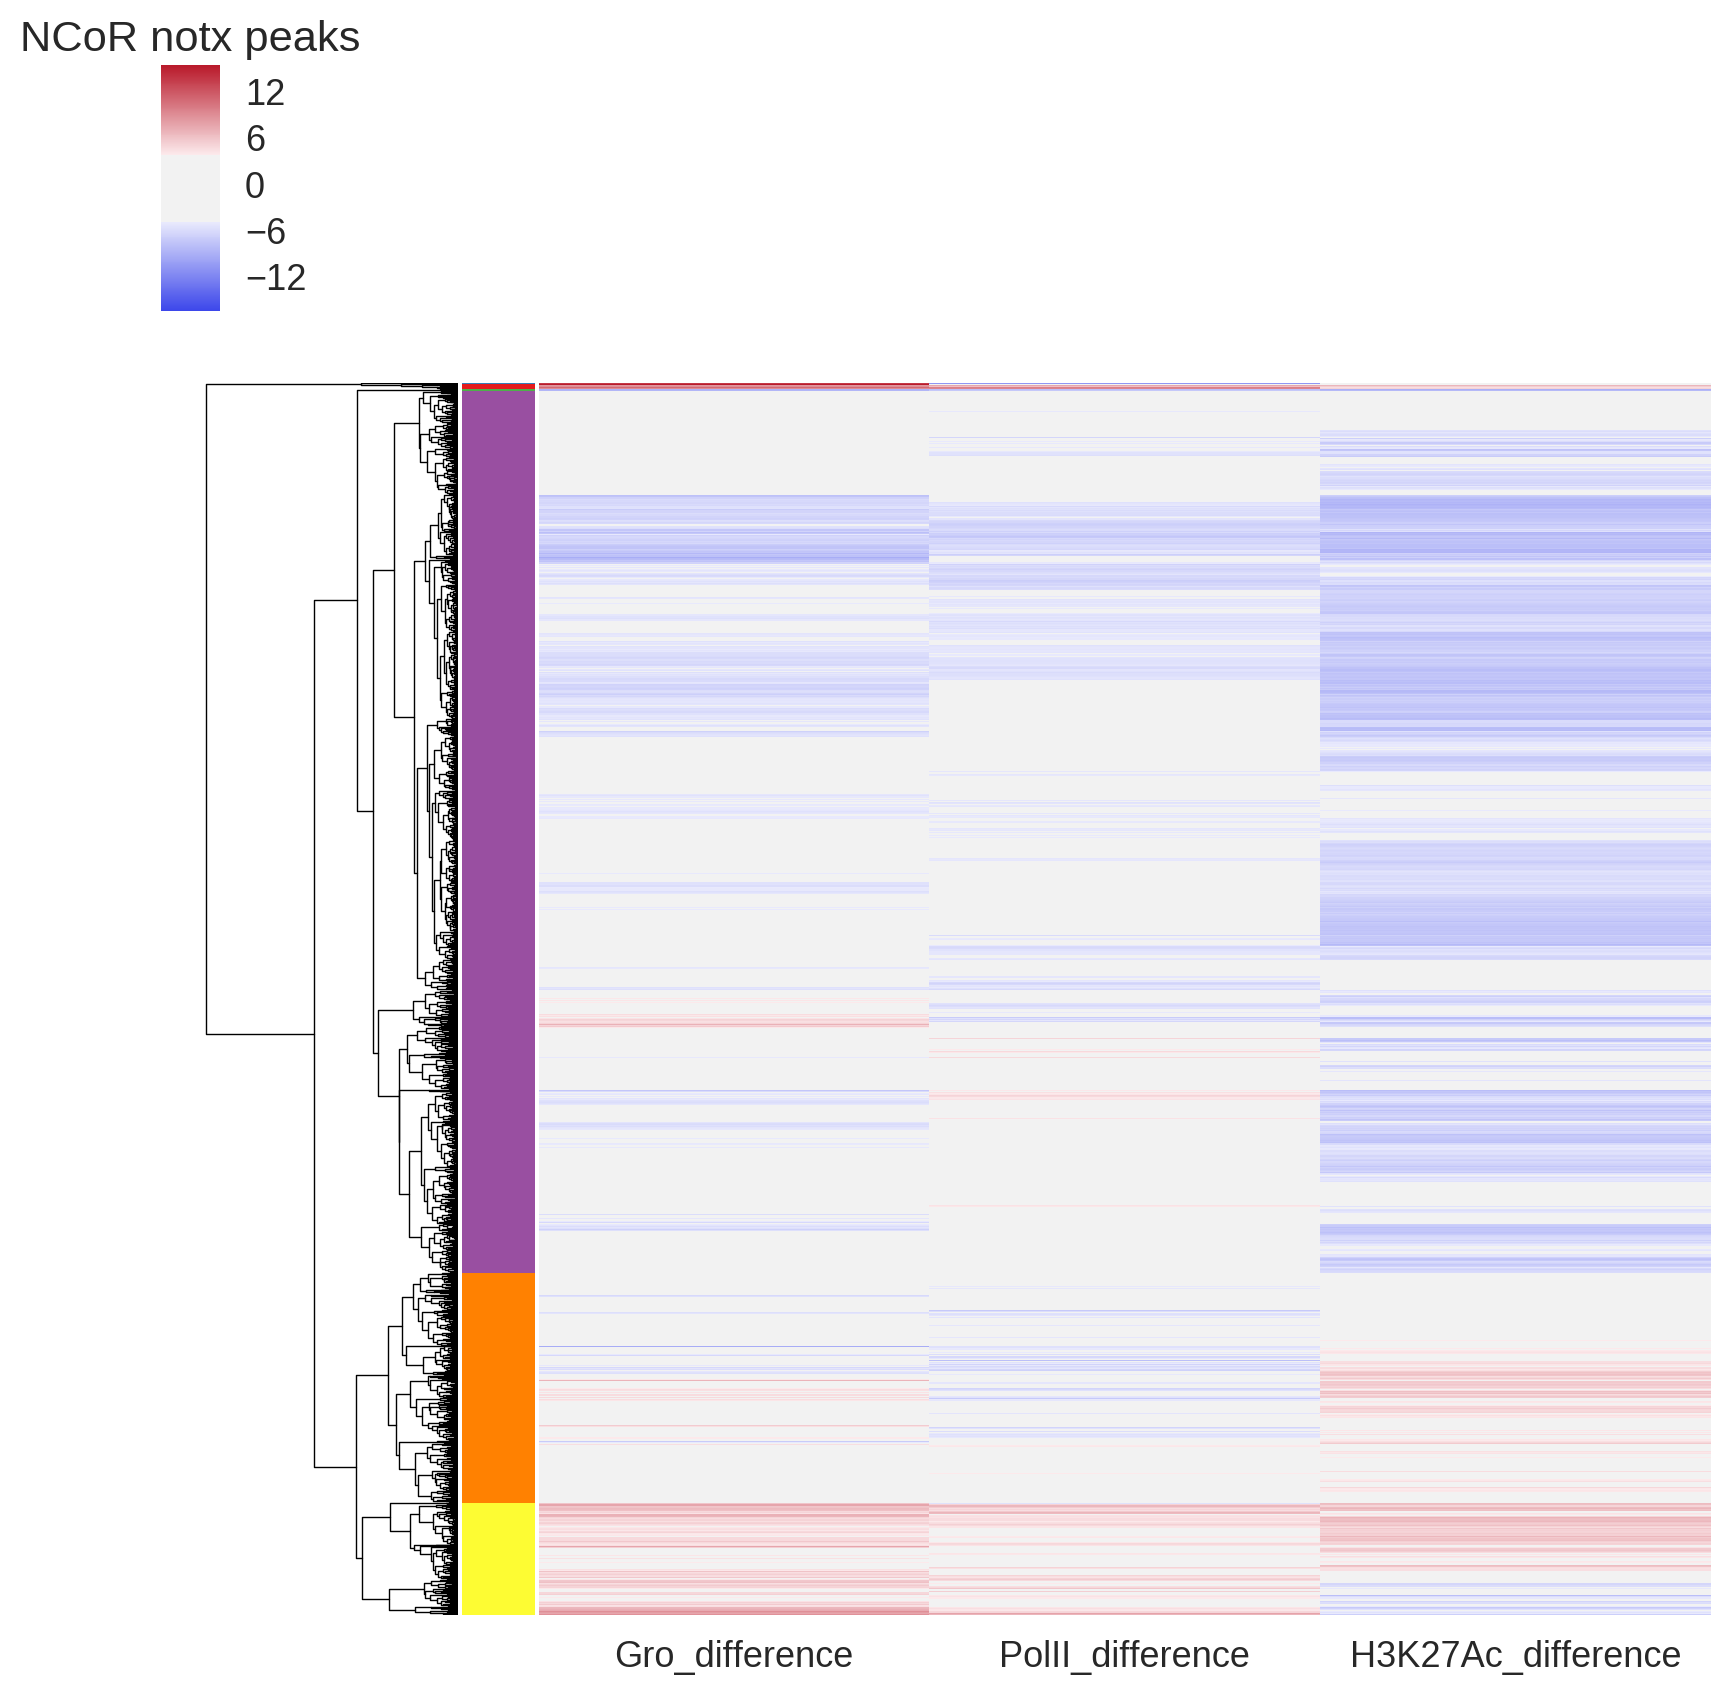

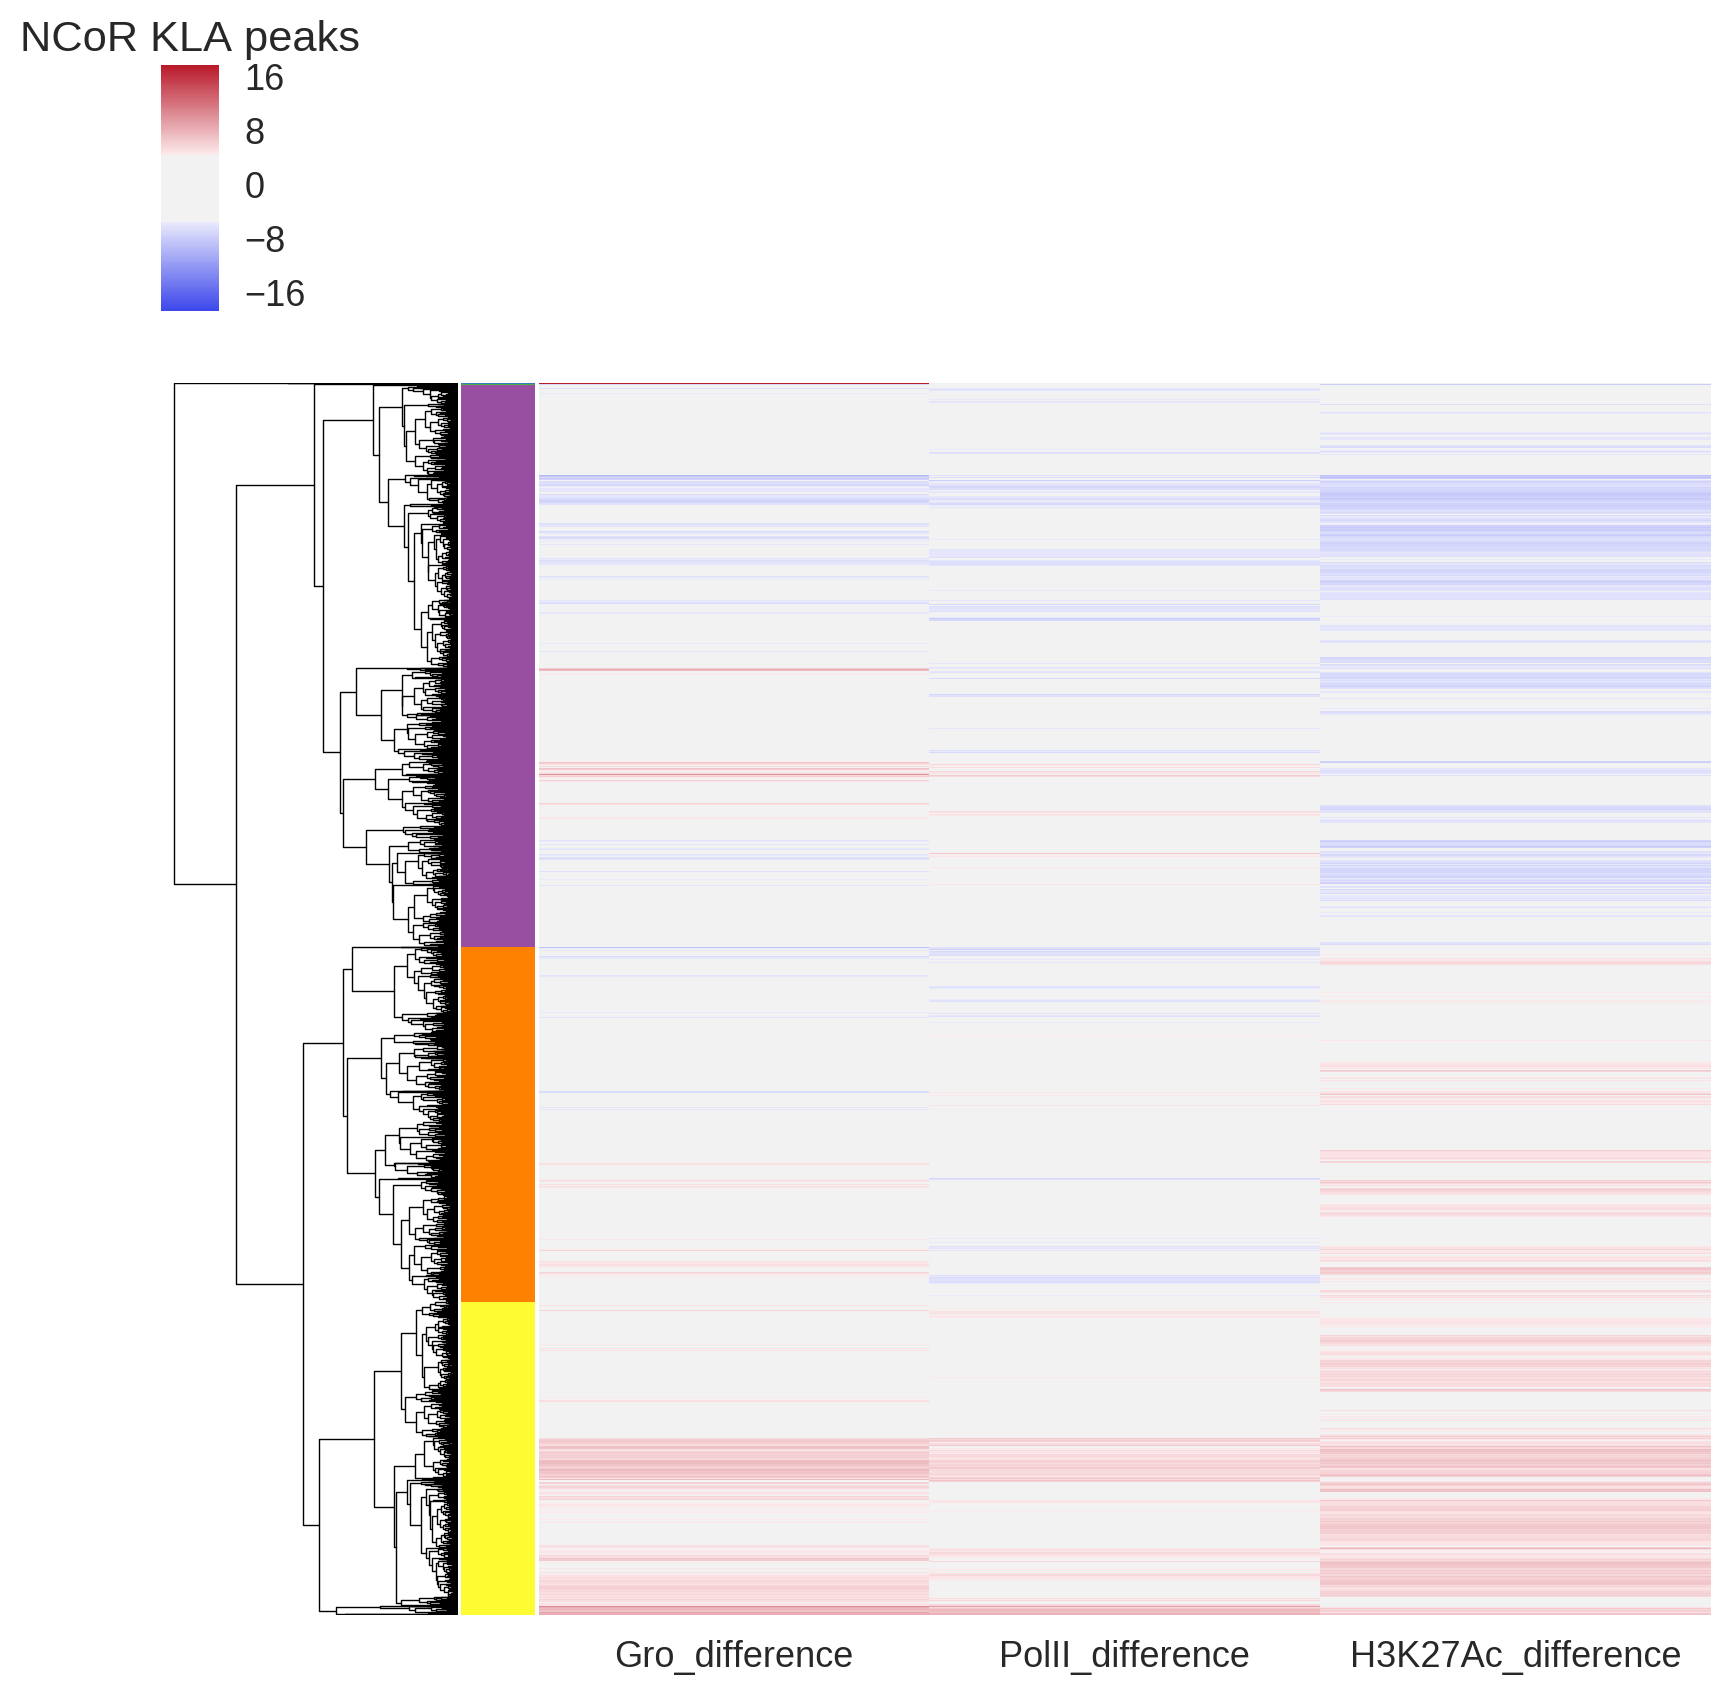

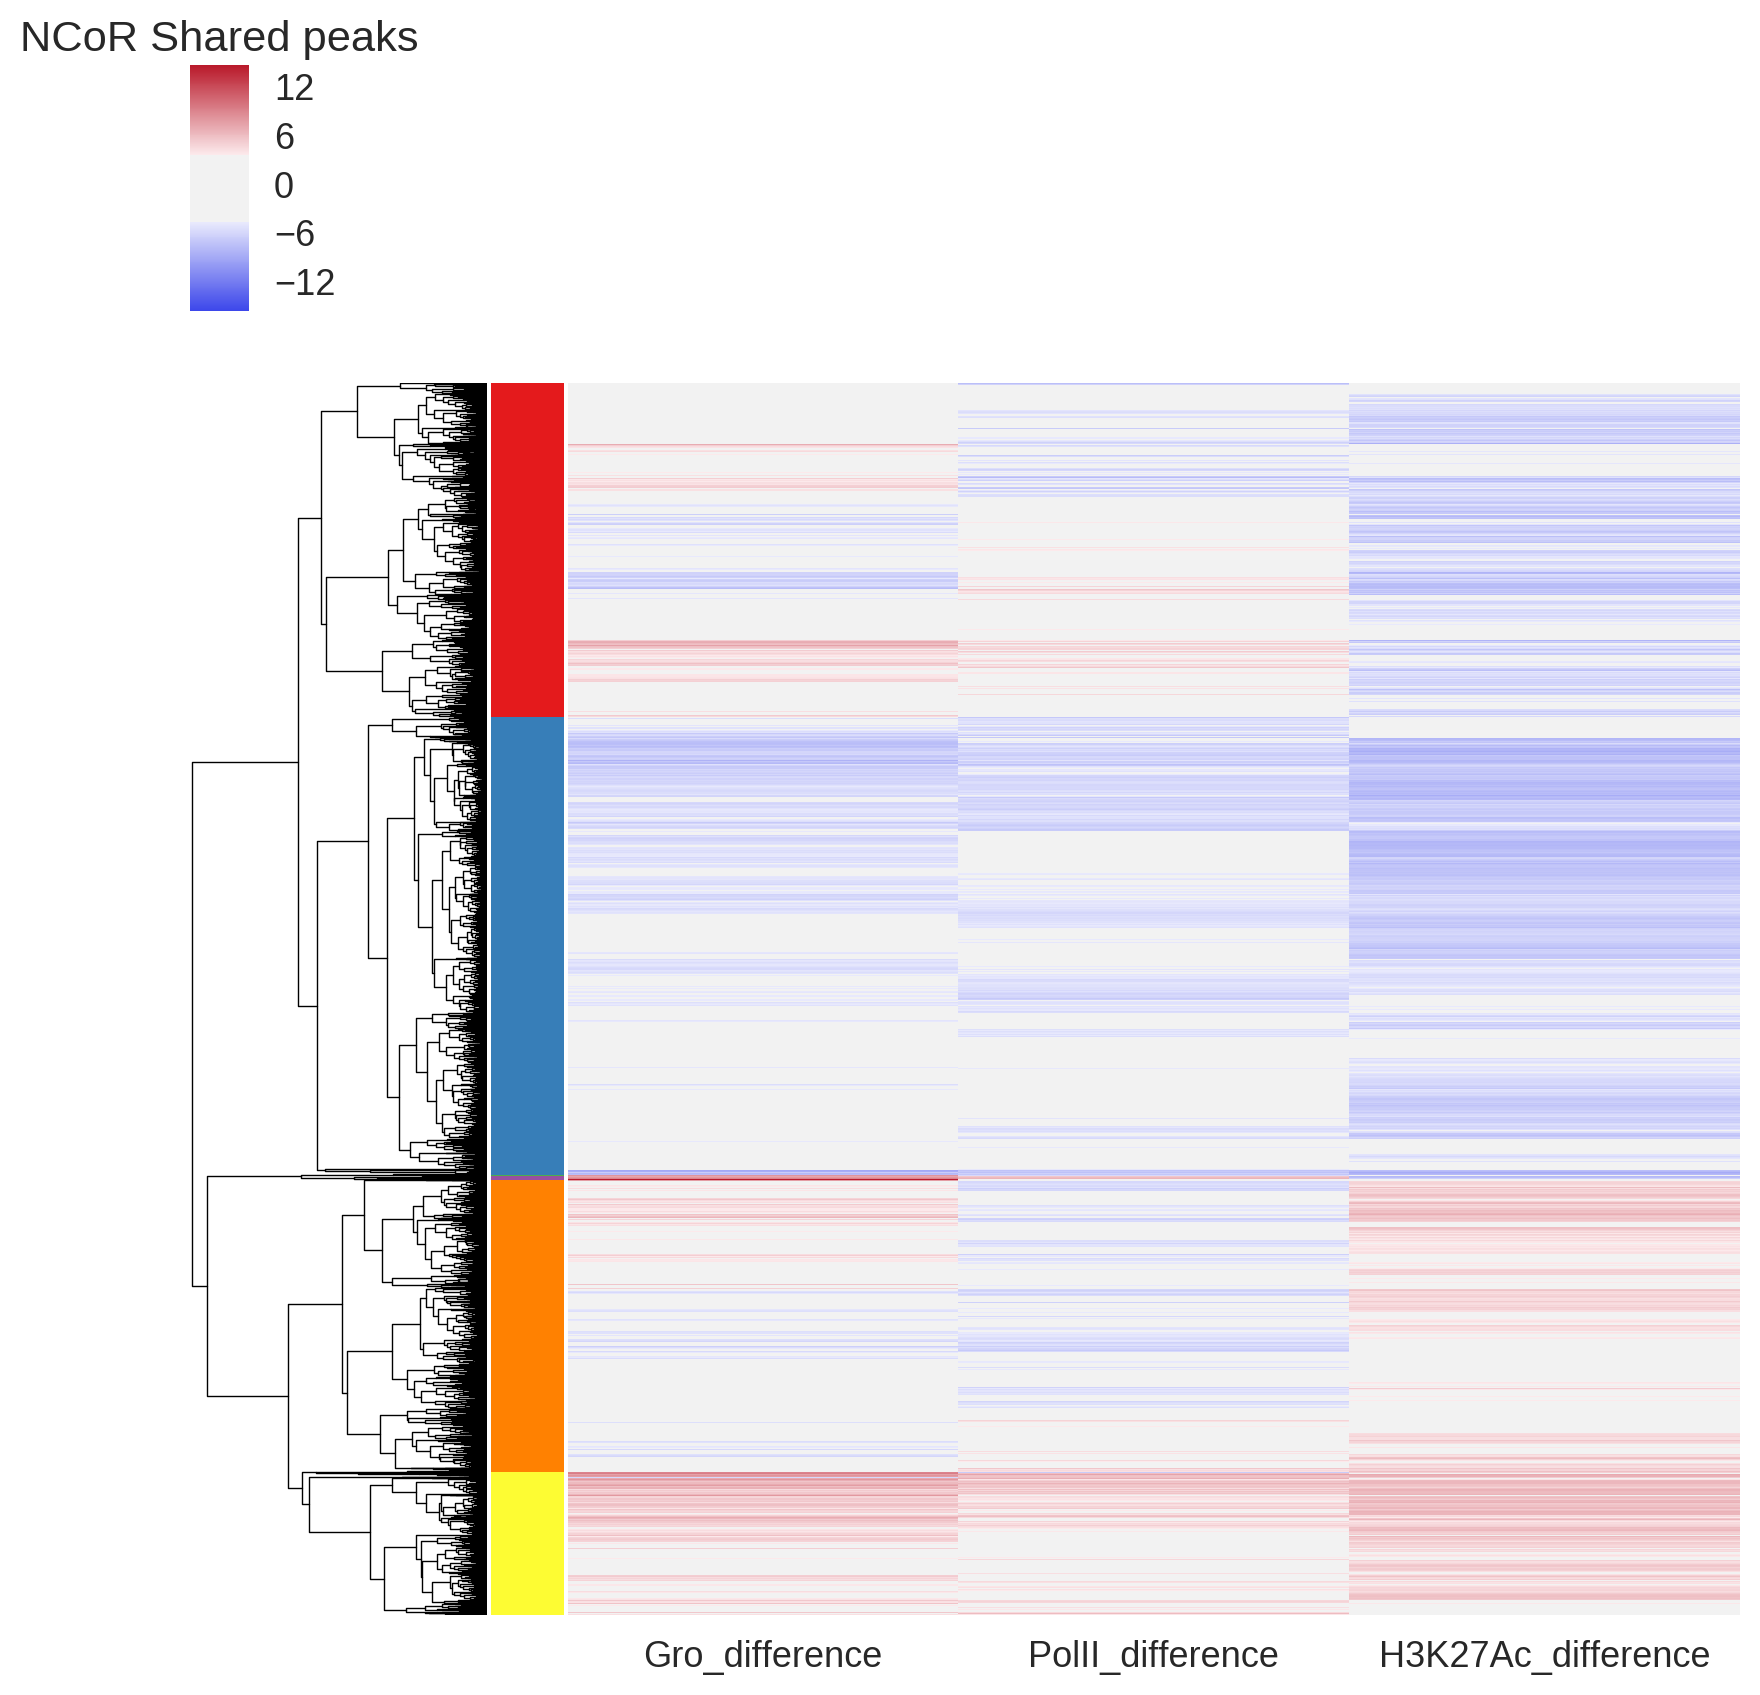

In [60]:
# for notx peaks
separation=70
numRowClusters = 6
data = notx_difference_frame.ix[:,-3:]

cg_notx = pickle.load(open('cg_notx.pickle','rb'))
reordered_indices = cg_notx.dendrogram_row.reordered_ind
row_linkage = cg_notx.dendrogram_row.linkage
row_flatCluster = scipy.cluster.hierarchy.fcluster(row_linkage, numRowClusters, criterion="maxclust")
row_colors = [colorDict[row_flatCluster[i] -1] for i in range(len(data.index))]
sns.clustermap(data, 
             row_linkage = row_linkage,
             col_cluster=False,
             row_colors = row_colors,
             yticklabels = False,
             cmap=sns.diverging_palette(265, 10, s=90, l=40, sep=separation, as_cmap=True)
             )
plt.title('NCoR notx peaks')
plt.show()

# for KLA peaks
data = kla_difference_frame.ix[:,-3:]

cg_kla = pickle.load(open('cg_kla.pickle','rb'))

reordered_indices = cg_kla.dendrogram_row.reordered_ind
row_linkage = cg_kla.dendrogram_row.linkage
row_flatCluster = scipy.cluster.hierarchy.fcluster(row_linkage, numRowClusters, criterion="maxclust")
row_colors = [colorDict[row_flatCluster[i] -1] for i in range(len(data.index))]

sns.clustermap(data, 
             row_linkage = row_linkage,
             col_cluster=False,
             row_colors = row_colors,
             yticklabels = False,
             cmap=sns.diverging_palette(265, 10, s=90, l=40, sep=separation, as_cmap=True)
             )
plt.title('NCoR KLA peaks')
plt.show()

# for shared peaks
data = shared_difference_frame.ix[:,-3:]

cg_shared = pickle.load(open('cg_shared.pickle','rb'))

reordered_indices = cg_shared.dendrogram_row.reordered_ind
row_linkage = cg_shared.dendrogram_row.linkage
row_flatCluster = scipy.cluster.hierarchy.fcluster(row_linkage, numRowClusters, criterion="maxclust")
row_colors = [colorDict[row_flatCluster[i] -1] for i in range(len(data.index))]

sns.clustermap(data, 
             row_linkage = row_linkage,
             col_cluster=False,
             row_colors = row_colors,
             yticklabels = False,
             cmap=sns.diverging_palette(265, 10, s=90, l=40, sep=separation, as_cmap=True)
             )
plt.title('NCoR Shared peaks')
plt.show()


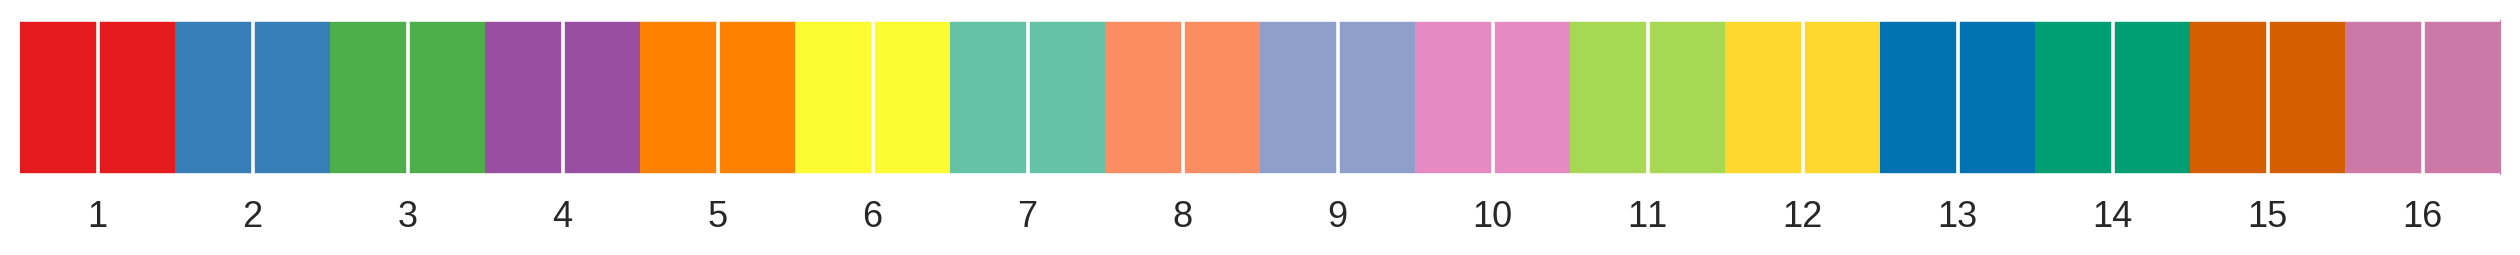

In [61]:
sns.palplot(list(colorDict.values()))
plt.xticks(range(0,16), range(1,17));

/bioinformatics/software/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index,col_indexer] = value instead
/bioinformatics/software/anaconda3/lib/python3.4/site-packages/seaborn/categorical.py:1613: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)
/bioinformatics/software/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


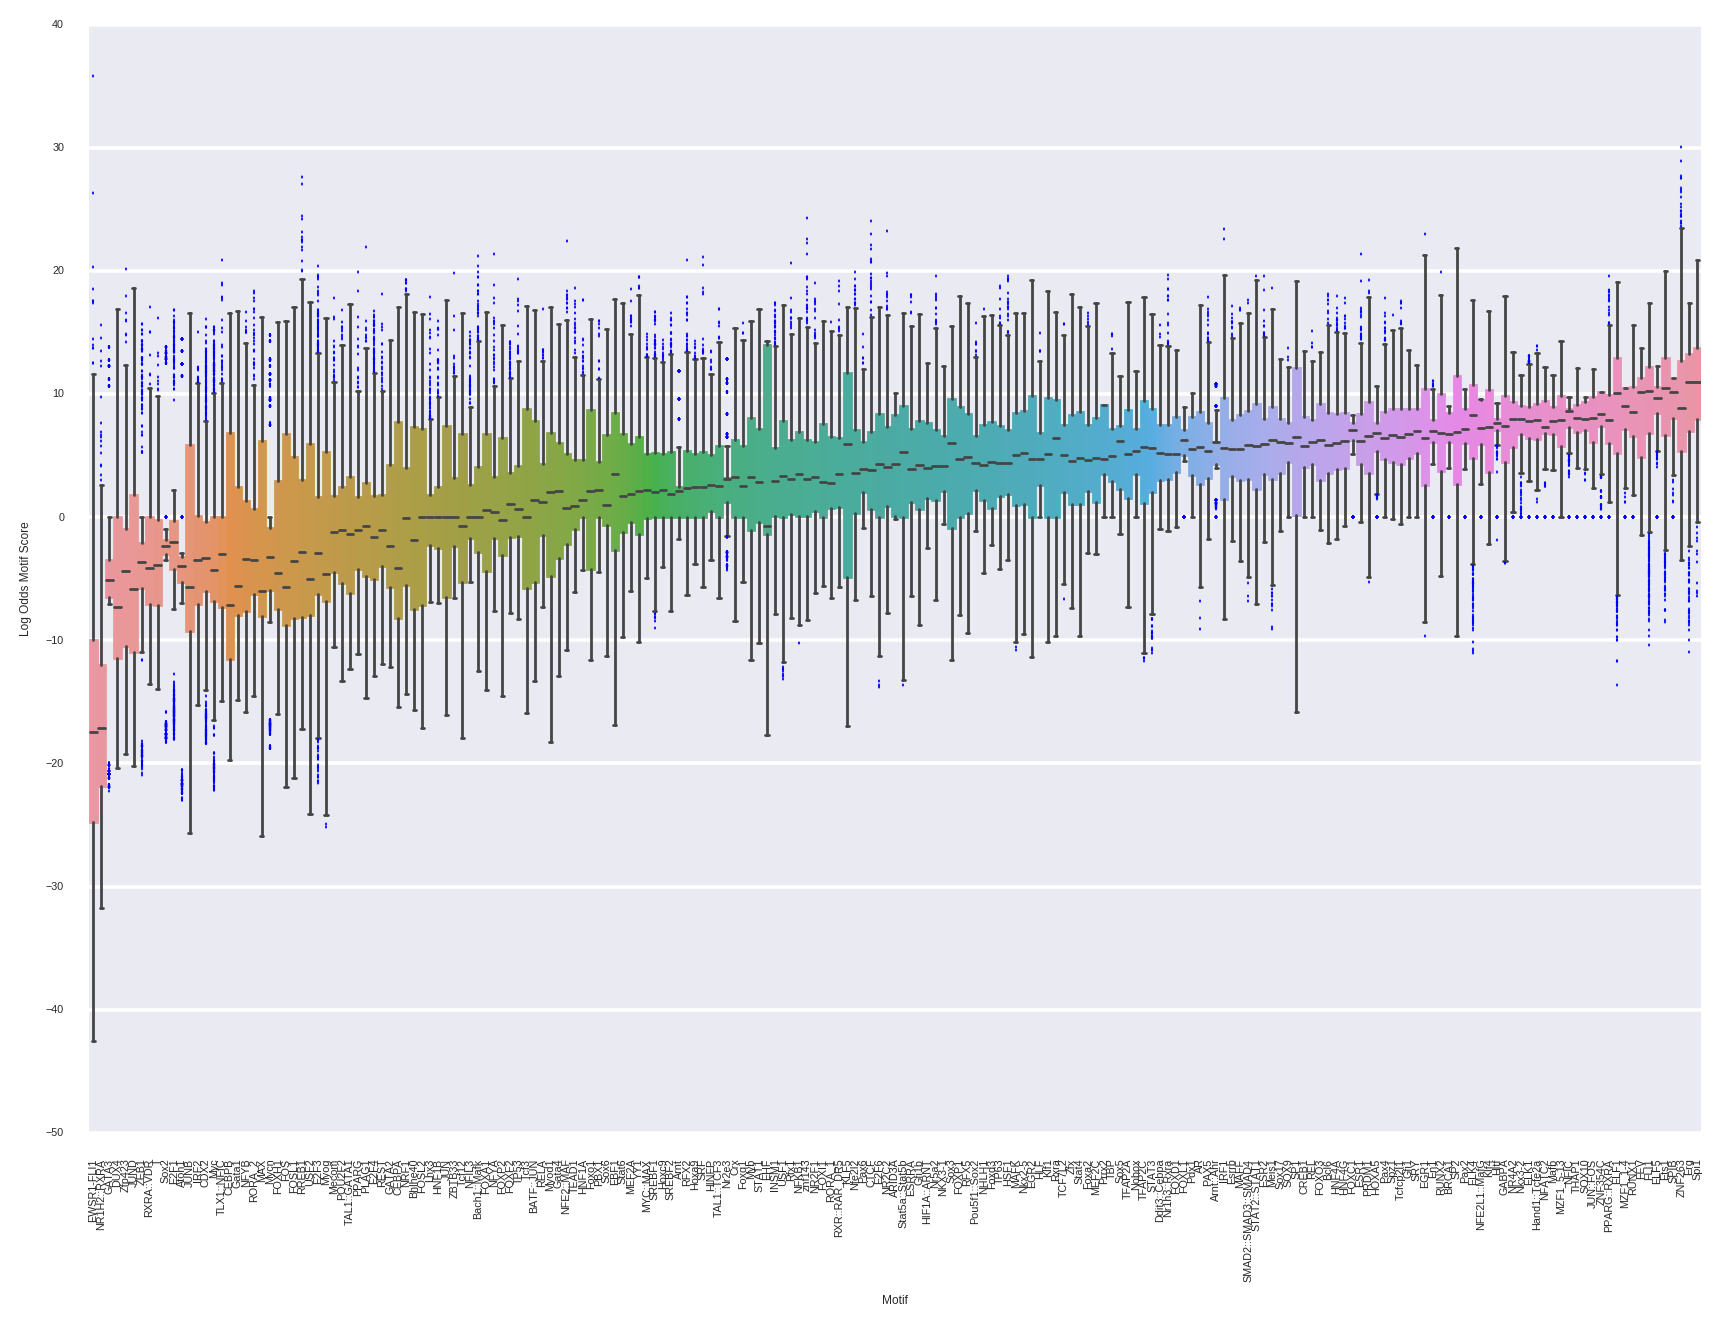

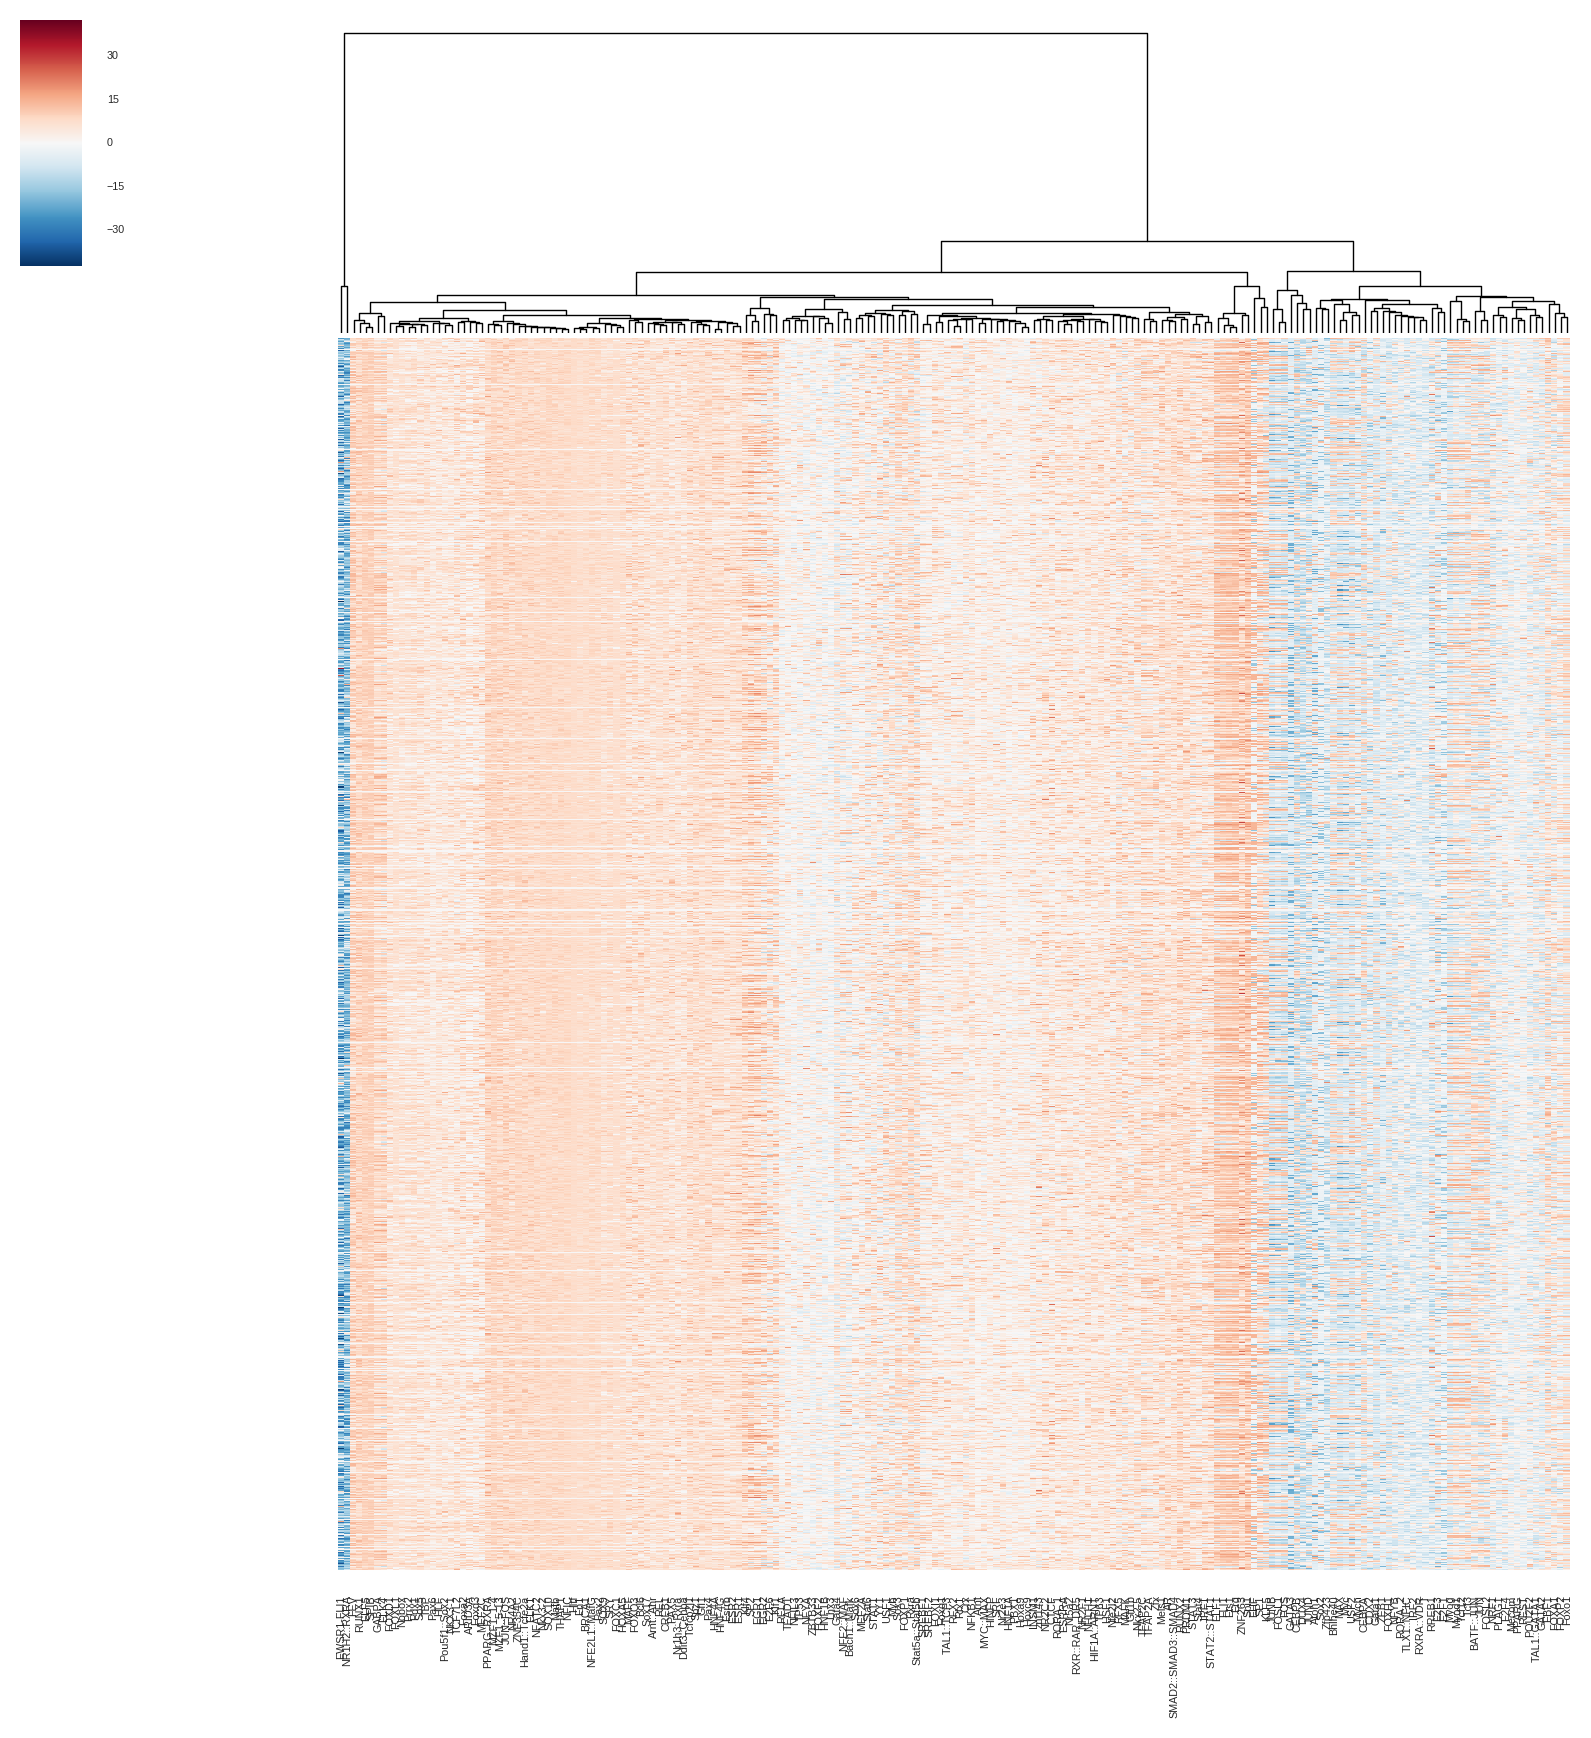

In [114]:
### score motifs for each cluster for each category of peaks ###

### for notx peaks
cg_notx = pickle.load(open('cg_notx.pickle','rb'))
notx_difference_frame['cluster'] = scipy.cluster.hierarchy.fcluster(cg_notx.dendrogram_row.linkage, numRowClusters, criterion="maxclust")

# peaks that look like activators
ids = notx_difference_frame[notx_difference_frame['cluster'] ==4]['ID'].values
scores = merged_motif_frame.ix[ids,:]

# plot distribution of motif scores
sns.set_context('talk', font_scale=0.3)
data_dict = {}
count = 0
sort_list = []
for col in scores.columns[3:]:
    data_dict[col] = scores[col].values
    sort_list.append((col, np.mean(scores[col].values)))
# sort_list = sorted(sort_list,key=lambda x:x[1])
sort_list = sorted(sort_list,key=lambda x:x[1])

order = [x[0] for x in sort_list]
sns.boxplot(pd.DataFrame(data_dict), 
            fliersize = 1.0,linewidth=1.0,
            order = order)
plt.xticks(rotation=90)
plt.xlabel("Motif")
plt.ylabel("Log Odds Motif Score")
plt.show()

sns.clustermap(scores.ix[:,3:],yticklabels=False, xticklabels=True, row_cluster=False)
plt.savefig('activator.pdf')
# for peaks that look like repressors
# ids = notx_difference_frame[notx_difference_frame['cluster'] ==6]['ID'].values
# scores = merged_motif_frame.ix[ids,:]



### for KLA peaks

### for shared peaks
sns.set_context('talk', font_scale=1.0)




/bioinformatics/software/anaconda3/lib/python3.4/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index,col_indexer] = value instead
/bioinformatics/software/anaconda3/lib/python3.4/site-packages/seaborn/categorical.py:1613: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)
/bioinformatics/software/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


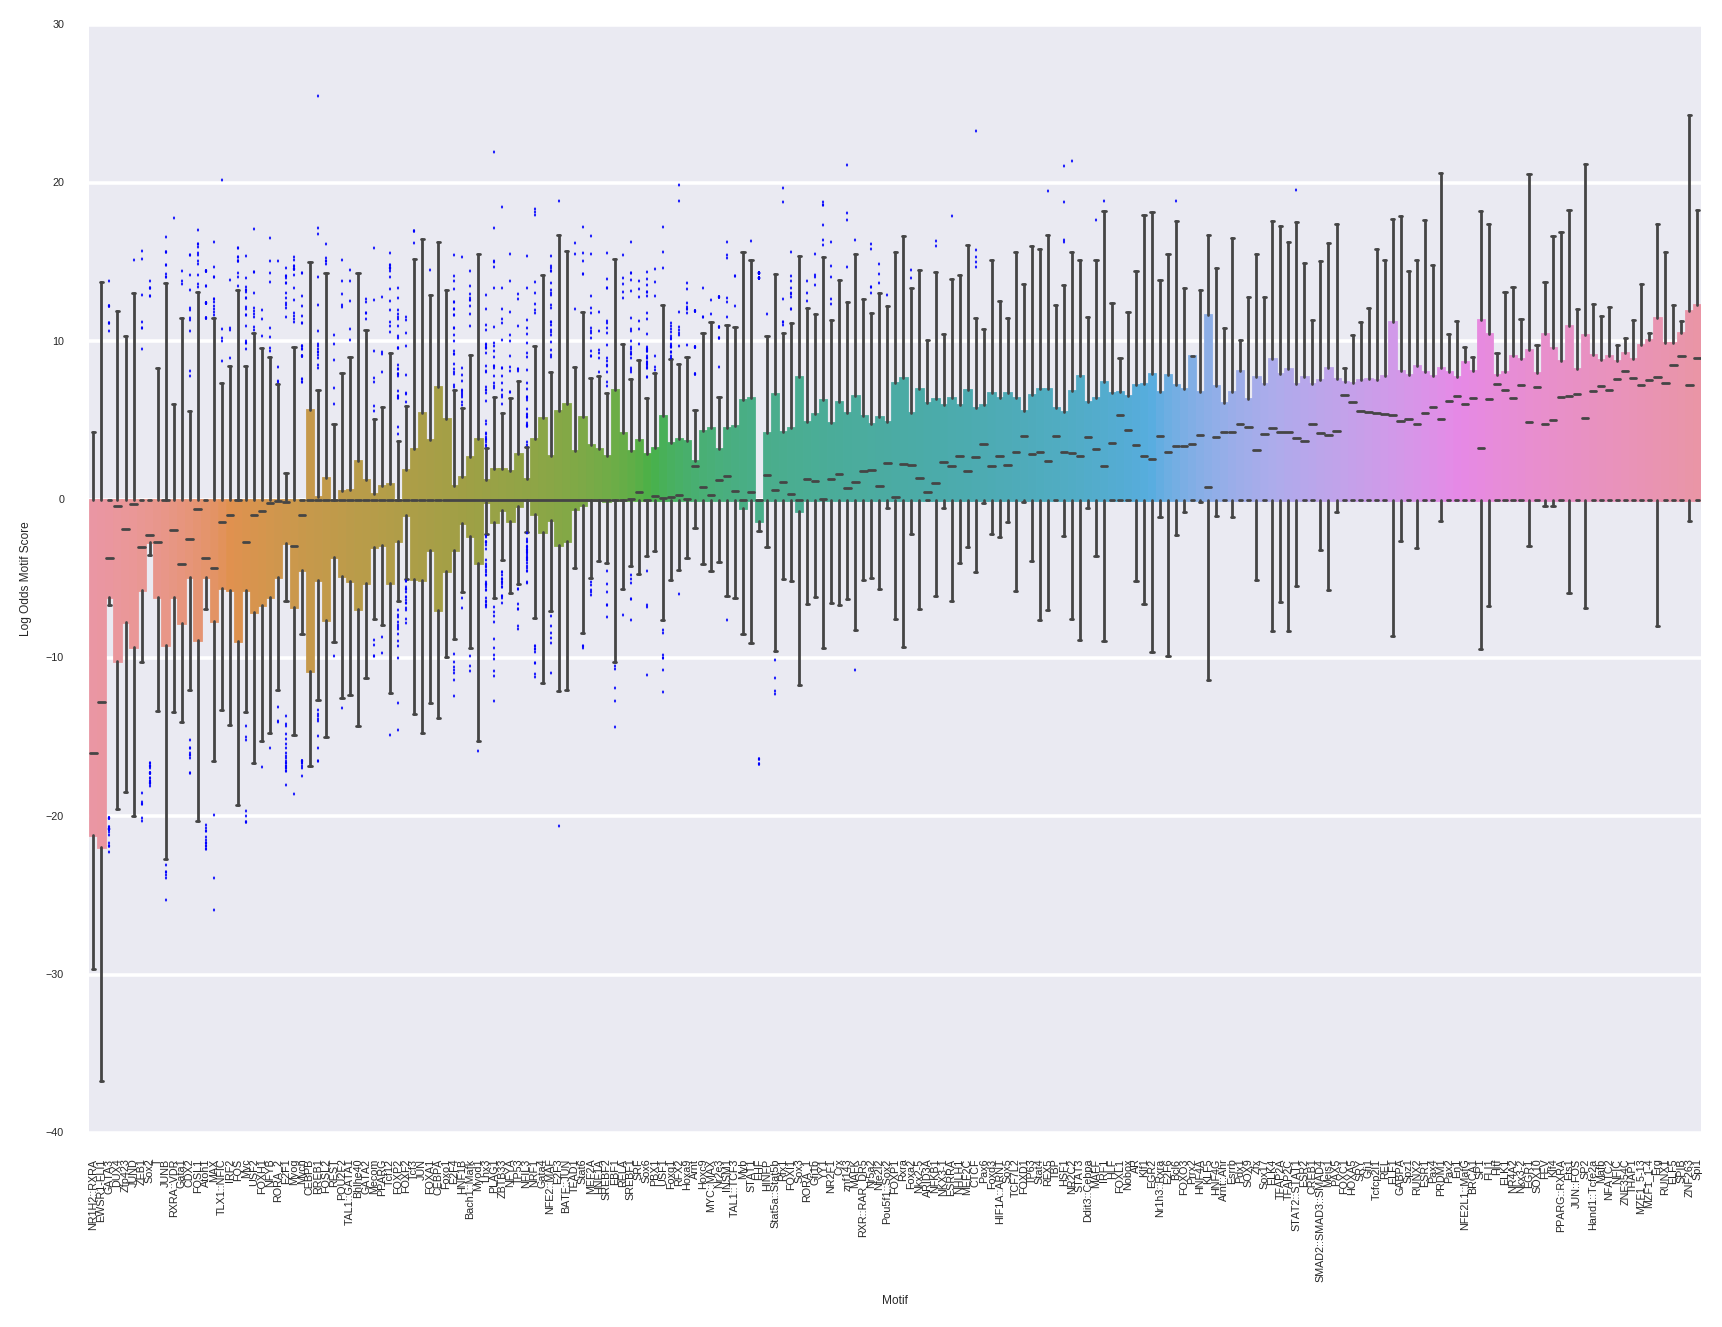

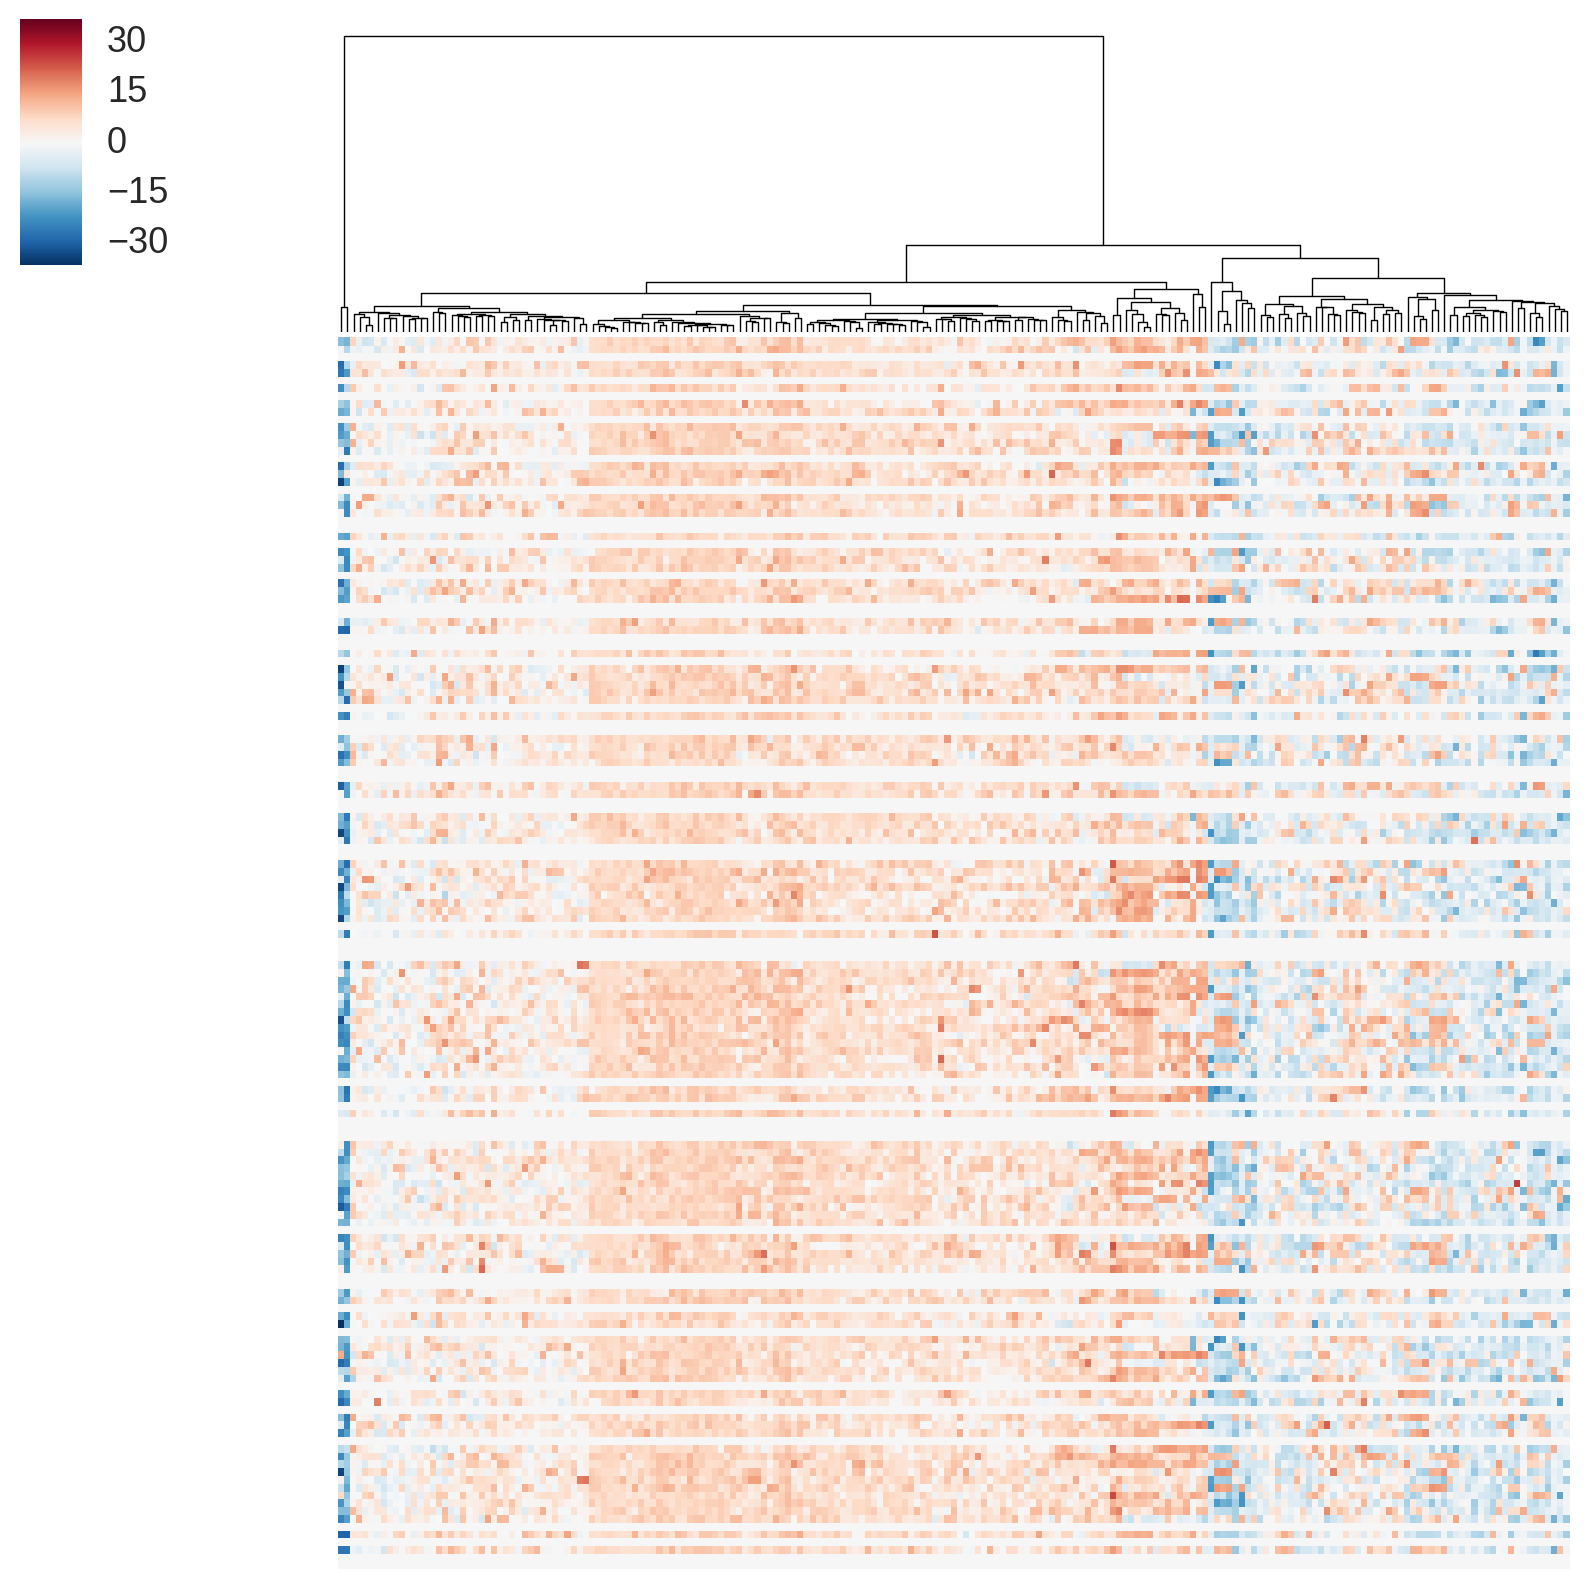

In [112]:
### score motifs for each cluster for each category of peaks ###

### for notx peaks
cg_notx = pickle.load(open('cg_notx.pickle','rb'))
notx_difference_frame['cluster'] = scipy.cluster.hierarchy.fcluster(cg_notx.dendrogram_row.linkage, numRowClusters, criterion="maxclust")

# peaks that look like activators
ids = notx_difference_frame[notx_difference_frame['cluster'] ==6]['ID'].values
scores = merged_motif_frame.ix[ids,:]

# plot distribution of motif scores
sns.set_context('talk', font_scale=0.3)
data_dict = {}
count = 0
sort_list = []
for col in scores.columns[3:]:
    data_dict[col] = scores[col].values
    sort_list.append((col, np.mean(scores[col].values)))
# sort_list = sorted(sort_list,key=lambda x:x[1])
sort_list = sorted(sort_list,key=lambda x:x[1])

order = [x[0] for x in sort_list]
sns.boxplot(pd.DataFrame(data_dict), 
            fliersize = 1.0,linewidth=1.0,
            order = order)
plt.xticks(rotation=90)
plt.xlabel("Motif")
plt.ylabel("Log Odds Motif Score")
plt.show()
sns.set_context('talk', font_scale=1.0)

sns.clustermap(scores.ix[:,3:],yticklabels=False, xticklabels=False, row_cluster=False)
# for peaks that look like repressors
# ids = notx_difference_frame[notx_difference_frame['cluster'] ==6]['ID'].values
# scores = merged_motif_frame.ix[ids,:]



### for KLA peaks

### for shared peaks




In [106]:
from sklearn import preprocessing
normedScores = preprocessing.normalize(scores.ix[:,3:])
normed_frame = pd.DataFrame(normedScores)
normed_frame.columns = merged_motif_frame.columns[3:]
sns.boxplot(scores.ix[3:])
plt.show()
sns.boxplot(normed_frame)
plt.show()
sns.clustermap(normed_frame)
plt.show()